In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from matplotlib.patches import Path, PathPatch
import pandas as pd
from shapely.geometry import Point, shape, Polygon
from shapely.ops import unary_union, cascaded_union
from geopandas.tools import sjoin
import geopandas as gpd
from netCDF4 import Dataset
from cartopy import crs as ccrs
from cartopy.io.shapereader import Reader
from sklearn.metrics import mean_squared_error
import scipy.stats as st
from sklearn.linear_model import LinearRegression
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.colors import ListedColormap

C:\Users\x12la\AppData\Local\Temp\ipykernel_2420\604465955.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  from geopandas.tools import sjoin


<h1> Load Data

In [2]:
# ## Upload vehicle emission datasets
# # FIVE Measures ..
# # NOx = NO + NO2  (Harkins, C., McDonald, B. C., Henze, D. K., & Wiedinmyer, C. (2021). A fuel-based method for updating mobile source emissions during the COVID-19 pandemic. Environmental Research Letters. https://doi.org/10.1088/1748-9326/ac0660)
# # from McDonald, B. C., Goldstein, A. H., & Harley, R. A. (2015). Long-Term Trends in California Mobile Source Emissions and Ambient Concentrations of Black Carbon and Organic Aerosol. Environmental Science & Technology, 49(8), 5178–5188. https://doi.org/10.1021/es505912b
five= gpd.read_file('five_1_33km_cons_annual.shp') #units ton/km$^2$/hour
five_new= five.to_crs('EPSG:4326')

#LADCO setup described here:  https://doi.org/10.1029/2022JD037942
ladco =  gpd.read_file('ladco_1_33km_cons_annual.shp')
ladco_new= ladco.to_crs('EPSG:4326')
                      
# paper currently being written 
#rowan = gpd.read_file('uvm_1_33km_cons_annual.shp') #units tons/km2/hour
rowan = gpd.read_file('uvm_1_33km_annual.shp')
rowan_new = rowan.to_crs('EPSG:4326')
rowan_new['NOX'] = rowan_new['new_NOX']
rowan_new['PM25'] = rowan_new['new_PM25']

# NEMO https://www.nature.com/articles/s41597-022-01790-9 
nemo = gpd.read_file('nemo_1_33km_cons_annual.shp') #units tons/km2/hour
nemo_new= nemo.to_crs('EPSG:4326')

#cook county il
cmap_cty = gpd.read_file('C:/Users/x12la/Desktop/Scripts/CMAP_cty.shp')
cmap_cty = cmap_cty.to_crs('EPSG:4326')

In [3]:
#primary roads
primary_roads = gpd.read_file('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp')
primary_roads = primary_roads.to_crs('EPSG:4326')

<h1> Clip data for Greater Chicago Region

In [4]:
# #Clip geopandas files to chicago 
cmap_roads = gpd.clip(primary_roads, cmap_cty.to_crs('EPSG:4326'))
cmap_five = gpd.clip(five_new, cmap_cty.to_crs('EPSG:4326'))
cmap_ladco = gpd.clip(ladco_new, cmap_cty.to_crs('EPSG:4326'))
cmap_rowan = gpd.clip(rowan_new, cmap_cty.to_crs('EPSG:4326'))
cmap_nemo = gpd.clip(nemo_new, cmap_cty.to_crs('EPSG:4326'))

<h1> Simulated vehicle NOX emissions

<h3> Plot simulated emissions spatially. Calculate localized max NOx and domain total NOx for absolute emissions (tons/year) and emission flux (tons/km2/year). 

C:\Users\x12la\AppData\Local\Temp\ipykernel_2420\3928457806.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
C:\Users\x12la\AppData\Local\Temp\ipykernel_2420\3928457806.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


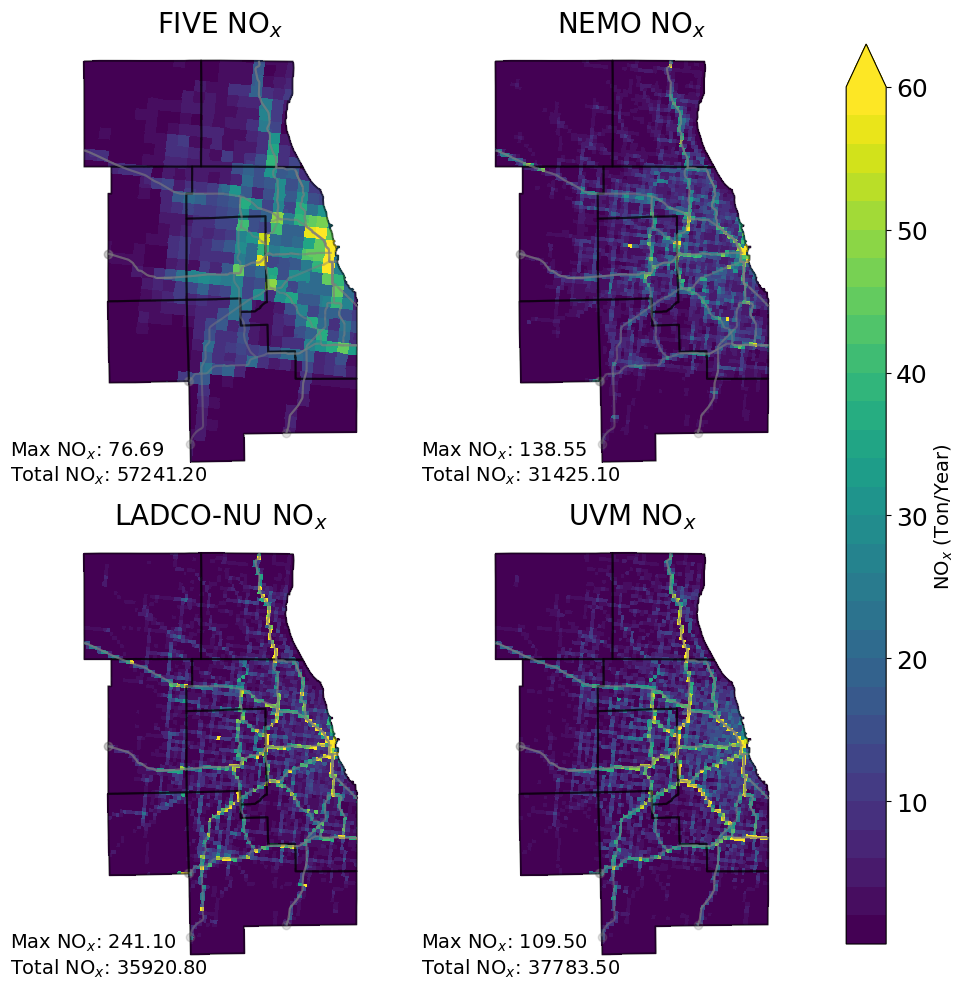

In [7]:
#################################
####### Absolute Emissions
##################################

# Create a discrete colormap based on Viridis
viridis_colors = plt.cm.viridis(np.linspace(0, 1, 30))  # Get 20 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(viridis_colors)

# Create subplots with 2 rows and 2 columns and larger figsize
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plotting NOx figures with county boundaries and roads for the subplots
for i, cmap_data in enumerate([(cmap_five, 'FIVE'), (cmap_nemo, 'NEMO'), (cmap_ladco, 'LADCO-NU'), (cmap_rowan, 'UVM')]):
    row_index = i // 2  # Calculate row index
    col_index = i % 2   # Calculate column index
    cmap, label = cmap_data
    cmap.plot('NOX', ax=axs[row_index, col_index], vmax=60, cmap=cmap_discrete, legend=False, antialiased=False)
    cmap_cty.boundary.plot(ax=axs[row_index, col_index], color='k', alpha=0.5)  # Add county boundaries
    cmap_roads.plot(ax=axs[row_index, col_index], color='grey', alpha=0.25)  # Add roads
    axs[row_index, col_index].set_title(f'{label} NO$_x$', fontsize=20)
    
    # Annotate maximum NOx and domain NOx sum
    max_nox = round(cmap['NOX'].max(), 2)
    total_nox = round(cmap['NOX'].sum(), 1)
    axs[row_index, col_index].annotate(f'Max NO$_x$: {max_nox:.2f}\nTotal NO$_x$: {total_nox:.2f}',
                                       xy=(-.2, -0.01), xycoords='axes fraction',
                                       fontsize=14, ha='left', va='bottom')

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.05)  # Decrease wspace for less whitespace

# Adding a single colorbar to the right of all figures
cbar_ax = fig.add_axes([0.92, 0.05, 0.04, 0.9])  # [left, bottom, width, height]
cbar = plt.colorbar(axs[0, 0].collections[0], cax=cbar_ax, orientation='vertical', extend='max')  # Use the first subplot's collection for the colorbar
cbar.set_label('NO$_x$ (Ton/Year)', fontsize=14)
# Increase the tick mark label size
cbar.ax.tick_params(labelsize=18)  # Set tick label font size

# Turn off axis for all subplots
for ax in axs.flat:
    ax.set_axis_off()

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.savefig('NOX_1_33km_AllDatasets_2x2_discrete_colorbar.png')
plt.tight_layout()
plt.show()


C:\Users\x12la\AppData\Local\Temp\ipykernel_2420\3507224408.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
C:\Users\x12la\AppData\Local\Temp\ipykernel_2420\3507224408.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


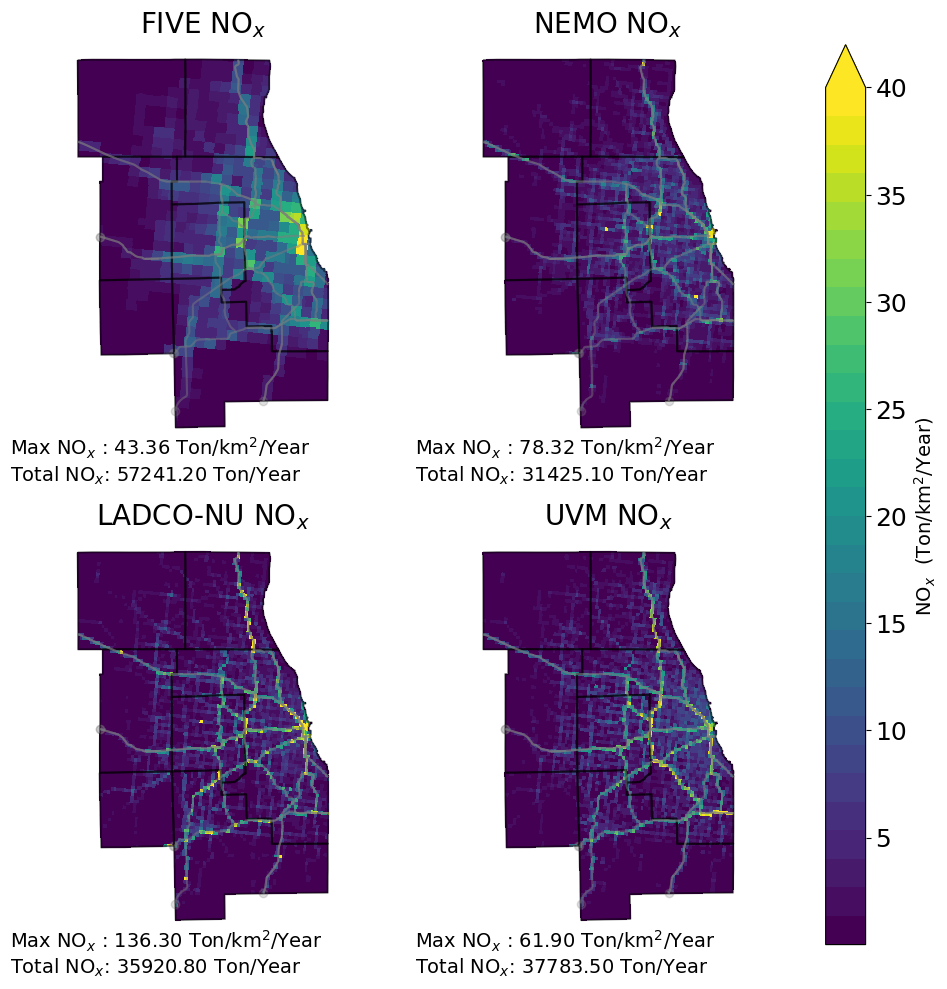

In [8]:
#################################
####### Emissions Flux
##################################

# Create a discrete colormap based on Viridis
viridis_colors = plt.cm.viridis(np.linspace(0, 1, 30))  # Get 30 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(viridis_colors)

# Area of a 1.33 km x 1.33 km grid cell (in km^2)
grid_cell_area = 1.33**2  # = 1.7689 km^2

# Create subplots with 2 rows and 2 columns and larger figsize
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# List of datasets to be processed and plotted
datasets = [(cmap_five, 'FIVE'), (cmap_nemo, 'NEMO'), (cmap_ladco, 'LADCO-NU'), (cmap_rowan, 'UVM')]

# Process each dataset and plot NOx 
for i, (cmap, label) in enumerate(datasets):
    # Calculate NOx  (Ton/Year/km^2)
    cmap['NOX_'] = cmap['NOX'] / grid_cell_area
    
    # Determine subplot location
    row_index = i // 2  # Calculate row index
    col_index = i % 2   # Calculate column index
    
    # Plot NOx 
    cmap.plot('NOX_', ax=axs[row_index, col_index], vmax=40, cmap=cmap_discrete, legend=False, antialiased=False)
    
    # Plot county boundaries and roads
    cmap_cty.boundary.plot(ax=axs[row_index, col_index], color='k', alpha=0.5)  # Add county boundaries
    cmap_roads.plot(ax=axs[row_index, col_index], color='grey', alpha=0.25)  # Add roads
    
    # Set title for each subplot
    axs[row_index, col_index].set_title(f'{label} NO$_x$ ', fontsize=20)
    
    # Annotate maximum NOx  and domain NOx  sum
    max_nox_ = round(cmap['NOX_'].max(), 2)
    total_nox_ = round(cmap['NOX'].sum(), 1)
    axs[row_index, col_index].annotate(f'Max NO$_x$ : {max_nox_:.2f} Ton/km$^2$/Year\nTotal NO$_x$: {total_nox_:.2f} Ton/Year',
                                       xy=(-.2, -0.1), xycoords='axes fraction',
                                       fontsize=14, ha='left', va='bottom')

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.05)  # Decrease wspace for less whitespace

# Adding a single colorbar to the right of all figures
cbar_ax = fig.add_axes([0.92, 0.05, 0.04, 0.9])# [left, bottom, width, height]
cbar = plt.colorbar(axs[0, 0].collections[0], cax=cbar_ax, orientation='vertical', extend='max')  # Use the first subplot's collection for the colorbar
cbar.set_label('NO$_x$  (Ton/km$^2$/Year)', fontsize=14)
# Increase the tick mark label size
cbar.ax.tick_params(labelsize=18)  # Set tick label font size

# Turn off axis for all subplots
for ax in axs.flat:
    ax.set_axis_off()

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.savefig('NOX_flux_1_33km_AllDatasets_2x2_discrete_colorbar_.png')
plt.tight_layout()
plt.show()

<h3> Plot spatial correlation between datasets & calculate correlation coefficient for both absolute emissions and emission flux

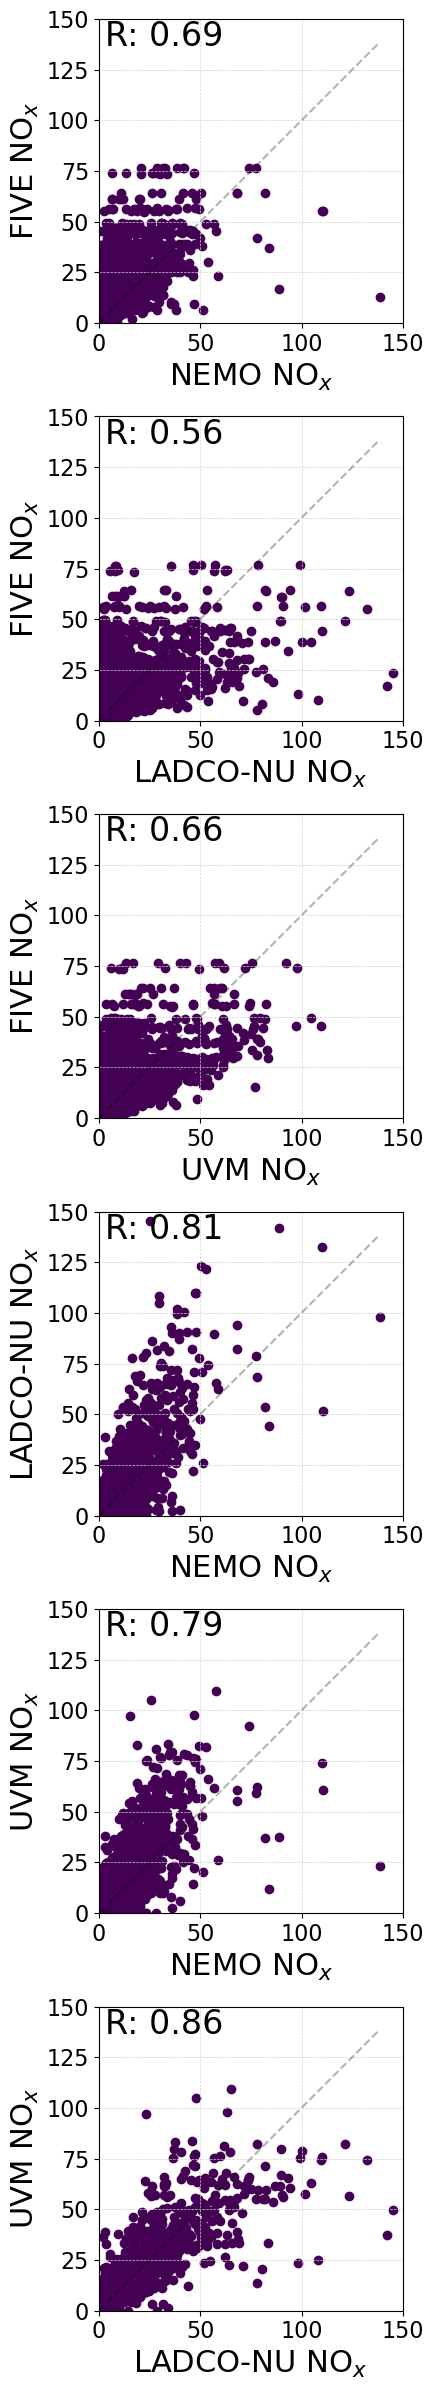

In [16]:
#################################
####### Absolute Emissions
##################################
fig = plt.figure(figsize=(12, 24))  # Set figure size

# Subplot grid layout with 5 rows
gs = fig.add_gridspec(6, 1)

# Function to plot correlation between two datasets
def plot_correlation(ax, x, y, label_x, label_y):
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    ax.scatter(x, y, color='#440154FF')  # Scatter plot
    ax.plot([x.min(), cmap_nemo['NOX'].max()], [x.min(), cmap_nemo['NOX'].max()], c='black', linestyle="--", alpha=0.3)  # Diagonal line
    correlation_coefficient = np.corrcoef(x, y)[0, 1]  # Correlation coefficient
    ax.text(0.02, 0.91, f'R: {correlation_coefficient:.2f}', transform=ax.transAxes, fontsize=24)  # Annotation for correlation coefficient
    #ax.text(0.02, 0.82, f'Y = {np.around(model.intercept_, 5)} + {np.around(model.coef_[0], 2)}X', transform=ax.transAxes, fontsize=18, color='red')  # Annotation for linear regression equation
    ax.set_xlabel(label_x, fontsize=22)  # X label
    ax.set_ylabel(label_y, fontsize=22)  # Y label
    ax.tick_params(axis='both', which='major', labelsize=16)  # Tick parameters
    ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)  # Grid
    ax.set_aspect('equal')  # Set aspect ratio to be equal
    ax.set_xlim(0, 150)  # Set x limits
    ax.set_ylim(0, 150)  # Set y limits

# First subplot (correlation plot between NEMO and FIVE)
ax1 = fig.add_subplot(gs[0, 0])
x_nemo = np.array(cmap_nemo['NOX'])
y_five = np.array(cmap_five['NOX'])
plot_correlation(ax1, x_nemo, y_five, 'NEMO NO$_x$', 'FIVE NO$_x$')

# Second subplot (correlation plot between NU CCRG and FIVE)
ax2 = fig.add_subplot(gs[1, 0])
x_ladco = np.array(cmap_ladco['NOX'])
plot_correlation(ax2, x_ladco, y_five, 'LADCO-NU NO$_x$', 'FIVE NO$_x$')

# Third subplot (correlation plot between UVM and FIVE)
ax3 = fig.add_subplot(gs[2, 0])
x_rowan = np.array(cmap_rowan['NOX'])
plot_correlation(ax3, x_rowan, y_five, 'UVM NO$_x$', 'FIVE NO$_x$')

# Fourth subplot (correlation plot between NEMO and NU CCRG)
ax1 = fig.add_subplot(gs[3, 0])
y_nemo = np.array(cmap_nemo['NOX'])
plot_correlation(ax1, x_nemo, x_ladco, 'NEMO NO$_x$', 'LADCO-NU NO$_x$')

# Fifth subplot (correlation plot between NEMO and UVM)
ax2 = fig.add_subplot(gs[4, 0])
plot_correlation(ax2, x_nemo, x_rowan, 'NEMO NO$_x$', 'UVM NO$_x$')

# six subplot (correlation plot between LADCO-NU and UVM)
ax3 = fig.add_subplot(gs[5, 0])
plot_correlation(ax3, x_ladco, x_rowan, 'LADCO-NU NO$_x$', 'UVM NO$_x$')

plt.tight_layout()  # Adjust layout
plt.savefig('Correlation_Plots_Column11_33km.png')  # Save figure
plt.show()  # Display figure


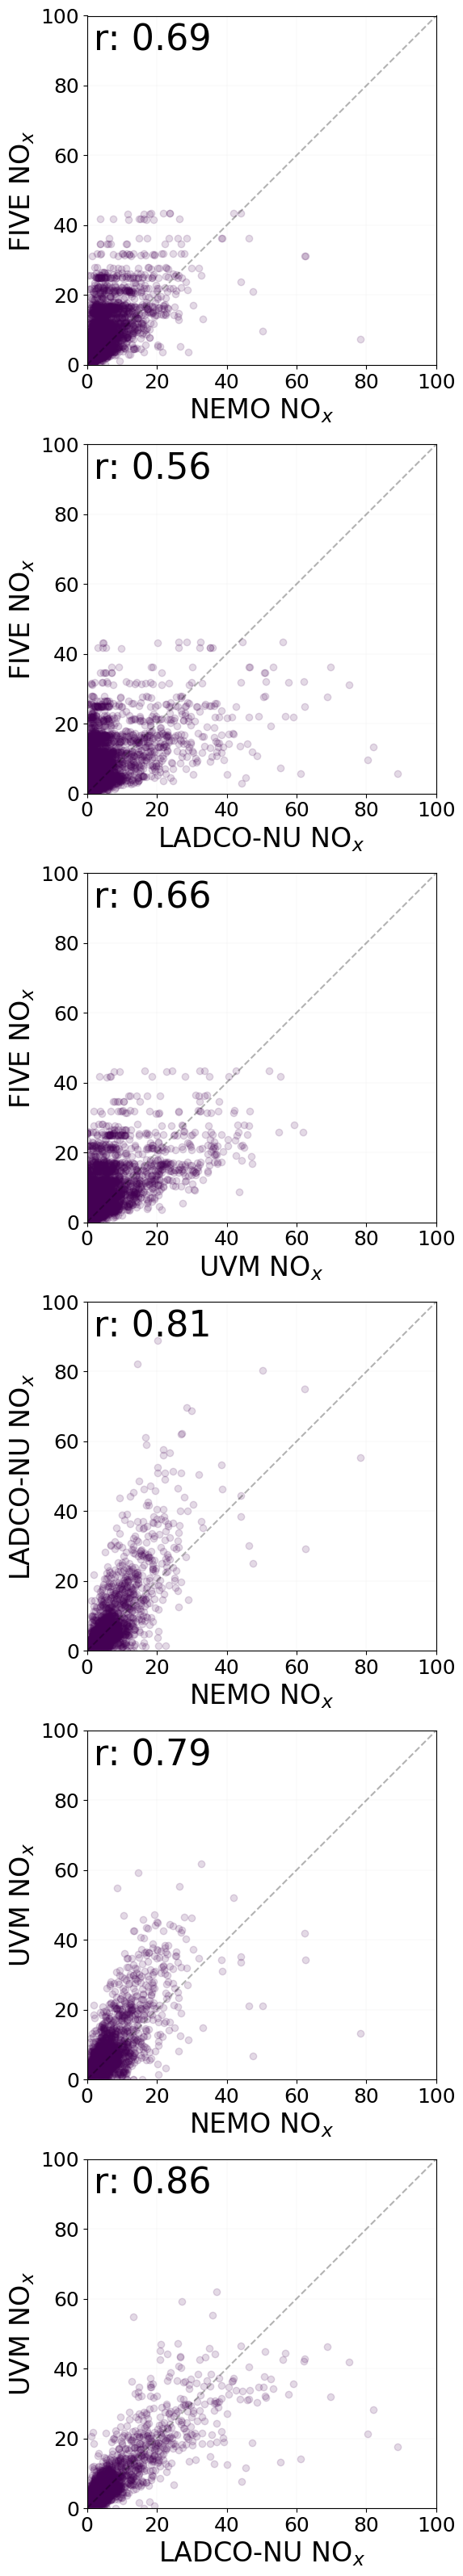

In [17]:
#################################
####### Emissions Flux
##################################

fig = plt.figure(figsize=(12, 32))  # Set figure size

# Subplot grid layout with 6 rows
gs = fig.add_gridspec(6, 1)

# Area of a 1.33 km x 1.33 km grid cell (in km^2)
grid_cell_area = 1.33**2  # = 1.7689 km^2

# Function to plot correlation between two datasets
def plot_correlation(ax, x, y, label_x, label_y):
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    ax.scatter(x, y, color='#440154FF', alpha=.15)  # Scatter plot
    ax.plot([0, 100], [0, 100], c='black', linestyle="--", alpha=0.3)  # Diagonal line
    correlation_coefficient = np.corrcoef(x, y)[0, 1]  # Correlation coefficient
    ax.text(0.02, 0.90, f'r: {correlation_coefficient:.2f}', transform=ax.transAxes, fontsize=32)  # Annotation for correlation coefficient
    ax.set_xlabel(label_x, fontsize=24)  # X label
    ax.set_ylabel(label_y, fontsize=24)  # Y label
    ax.tick_params(axis='both', which='major', labelsize=18)  # Tick parameters
    ax.grid(color='lightgrey', linestyle='--', linewidth=0.15)  # Grid
    ax.set_aspect('equal')  # Set aspect ratio to be equal
    ax.set_xlim(0, 100)  # Set x limits (adjust as needed)
    ax.set_ylim(0, 100)  # Set y limits (adjust as needed)

# Calculate NOx  for each dataset
x_nemo = np.array(cmap_nemo['NOX']) / grid_cell_area
x_ladco = np.array(cmap_ladco['NOX']) / grid_cell_area
x_rowan = np.array(cmap_rowan['NOX']) / grid_cell_area
y_five = np.array(cmap_five['NOX']) / grid_cell_area

# First subplot (correlation plot between NEMO and FIVE NOx )
ax1 = fig.add_subplot(gs[0, 0])
plot_correlation(ax1, x_nemo, y_five, 'NEMO NO$_x$ ', 'FIVE NO$_x$ ')

# Second subplot (correlation plot between LADCO-NU and FIVE NOx )
ax2 = fig.add_subplot(gs[1, 0])
plot_correlation(ax2, x_ladco, y_five, 'LADCO-NU NO$_x$ ', 'FIVE NO$_x$ ')

# Third subplot (correlation plot between UVM and FIVE NOx )
ax3 = fig.add_subplot(gs[2, 0])
plot_correlation(ax3, x_rowan, y_five, 'UVM NO$_x$ ', 'FIVE NO$_x$ ')

# Fourth subplot (correlation plot between NEMO and LADCO-NU NOx )
ax4 = fig.add_subplot(gs[3, 0])
plot_correlation(ax4, x_nemo, x_ladco, 'NEMO NO$_x$ ', 'LADCO-NU NO$_x$ ')

# Fifth subplot (correlation plot between NEMO and UVM NOx )
ax5 = fig.add_subplot(gs[4, 0])
plot_correlation(ax5, x_nemo, x_rowan, 'NEMO NO$_x$ ', 'UVM NO$_x$ ')

# Sixth subplot (correlation plot between LADCO
ax6 = fig.add_subplot(gs[5, 0])
plot_correlation(ax6, x_ladco, x_rowan, 'LADCO-NU NO$_x$', 'UVM NO$_x$')

plt.tight_layout()  # Adjust layout
plt.savefig('Correlation_Plots_NoxFlux_1_33km.png')  # Save figure
plt.show()  # Display figure

<h3> Identify localized grid cell maximums

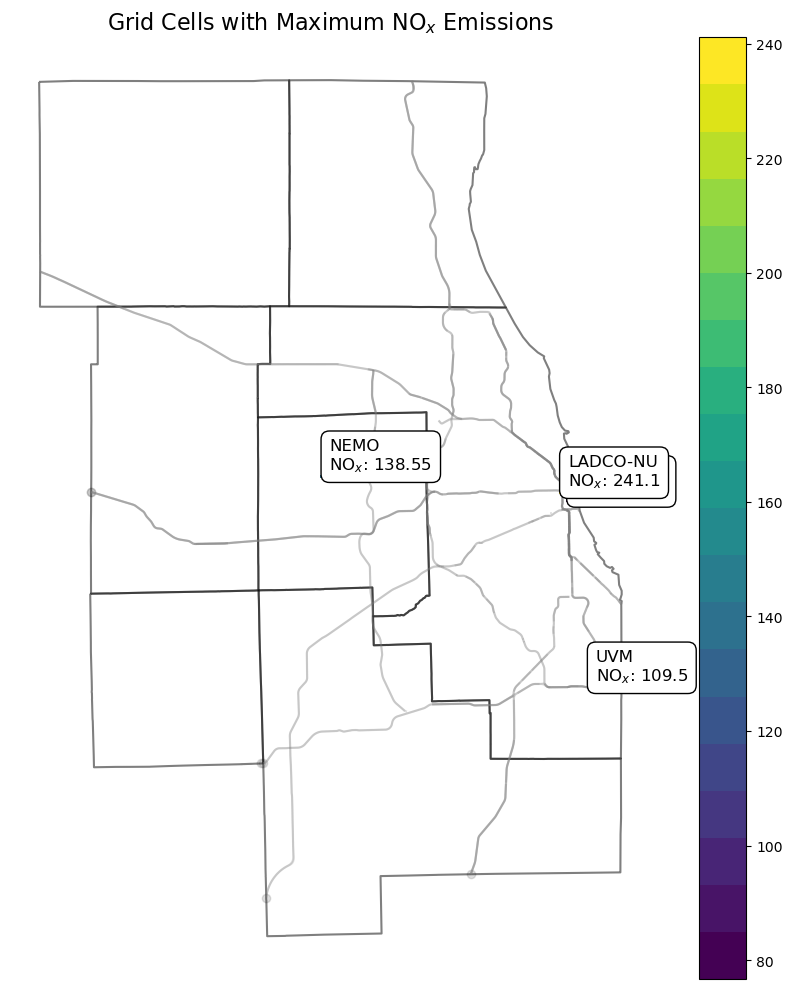

In [6]:
#################################
####### Absolute Emissions
##################################

# Create a discrete colormap based on Viridis
viridis_colors = plt.cm.viridis(np.linspace(0, 1, 20))  # Get 20 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(viridis_colors)

# Function to get the row with the maximum NOx value
def get_max_nox_row(gdf):
    return gdf.loc[gdf['NOX'].idxmax()]

# Get the row with the maximum NOx value for each dataset
max_nox_rows = [
    get_max_nox_row(cmap_five),
    get_max_nox_row(cmap_nemo),
    get_max_nox_row(cmap_ladco),
    get_max_nox_row(cmap_rowan)
]

# Create a new GeoDataFrame containing only the max NOx rows
max_nox_gdf = gpd.GeoDataFrame(max_nox_rows, crs=cmap_five.crs).reset_index(drop=True)

# Create a figure and axes for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the maximum NOx grid cells
max_nox_gdf.plot('NOX', ax=ax, cmap=cmap_discrete, legend=True, antialiased=False)

# Add county boundaries and roads to the plot
cmap_cty.boundary.plot(ax=ax, color='k', alpha=0.5)  # Add county boundaries
cmap_roads.plot(ax=ax, color='grey', alpha=0.25)  # Add roads

# Annotate the plot with the dataset labels and NOx values
labels = ['FIVE', 'NEMO', 'LADCO-NU', 'UVM']
for i, row in max_nox_gdf.iterrows():
    label = labels[i]
    max_nox = round(row['NOX'], 2)
    ax.annotate(f'{label}\nNO$_x$: {max_nox}', xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                xytext=(3, 3), textcoords='offset points', fontsize=12, color='black',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Set title and labels
ax.set_title('Grid Cells with Maximum NO$_x$ Emissions', fontsize=16)
ax.set_axis_off()  # Turn off axis

# Show the plot
plt.tight_layout()
plt.show()


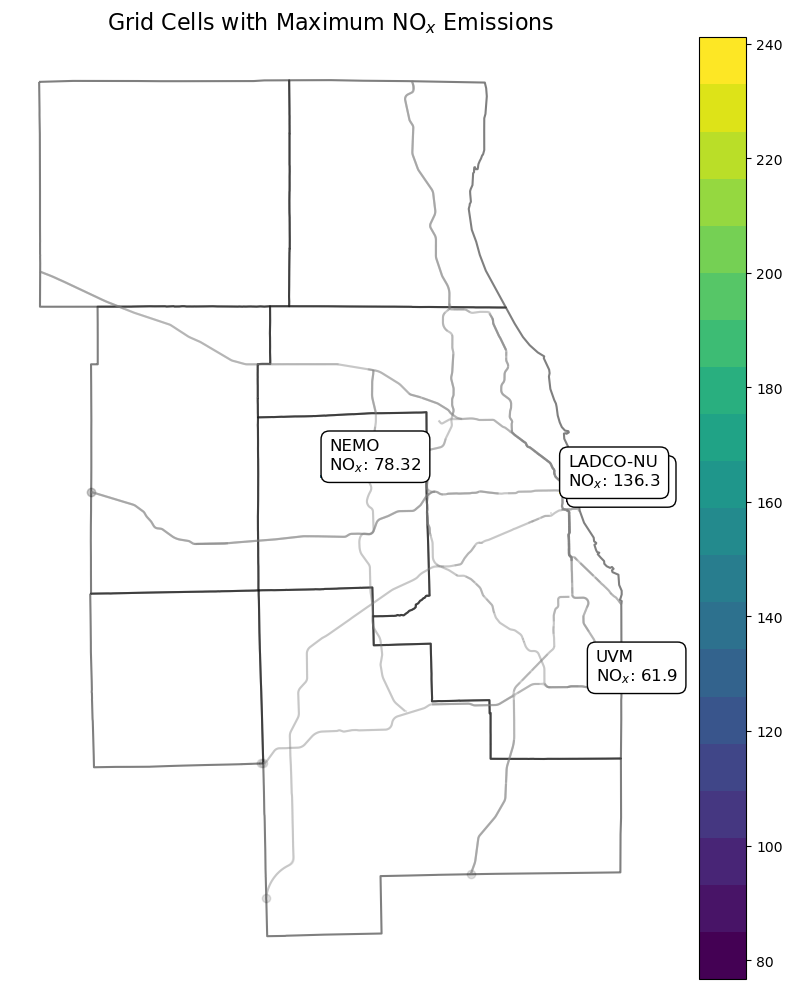

In [13]:
#################################
####### Emission Flux
##################################

# Create a discrete colormap based on Viridis
viridis_colors = plt.cm.viridis(np.linspace(0, 1, 20))  # Get 20 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(viridis_colors)

# Function to get the row with the maximum NOx value
def get_max_nox_row(gdf):
    return gdf.loc[(gdf['NOX']/grid_cell_area).idxmax()]

# Get the row with the maximum NOx value for each dataset
max_nox_rows = [
    get_max_nox_row(cmap_five),
    get_max_nox_row(cmap_nemo),
    get_max_nox_row(cmap_ladco),
    get_max_nox_row(cmap_rowan)
]

# Create a new GeoDataFrame containing only the max NOx rows
max_nox_gdf = gpd.GeoDataFrame(max_nox_rows, crs=cmap_five.crs).reset_index(drop=True)

# Create a figure and axes for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the maximum NOx grid cells
max_nox_gdf.plot('NOX', ax=ax, cmap=cmap_discrete, legend=True, antialiased=False)

# Add county boundaries and roads to the plot
cmap_cty.boundary.plot(ax=ax, color='k', alpha=0.5)  # Add county boundaries
cmap_roads.plot(ax=ax, color='grey', alpha=0.25)  # Add roads

# Annotate the plot with the dataset labels and NOx values
labels = ['FIVE', 'NEMO', 'LADCO-NU', 'UVM']
for i, row in max_nox_gdf.iterrows():
    label = labels[i]
    max_nox = round(row['NOX']/grid_cell_area, 2)
    ax.annotate(f'{label}\nNO$_x$: {max_nox}', xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                xytext=(3, 3), textcoords='offset points', fontsize=12, color='black',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Set title and labels
ax.set_title('Grid Cells with Maximum NO$_x$ Emissions', fontsize=16)
ax.set_axis_off()  # Turn off axis

# Show the plot
plt.tight_layout()
plt.show()


<h3> NOx box/whiskers

FIVE percentiles and mean:
  5th: 0.13
  25th: 1.07
  50th (median): 4.77
  75th: 13.57
  95th: 34.48
  mean: 9.43

NEMO percentiles and mean:
  5th: 0.00
  25th: 0.34
  50th (median): 2.09
  75th: 6.59
  95th: 20.72
  mean: 5.18

LADCO-NU percentiles and mean:
  5th: 0.00
  25th: 0.19
  50th (median): 1.76
  75th: 5.86
  95th: 28.01
  mean: 5.92

UVM percentiles and mean:
  5th: 0.00
  25th: 0.00
  50th (median): 1.95
  75th: 7.19
  95th: 29.26
  mean: 6.22



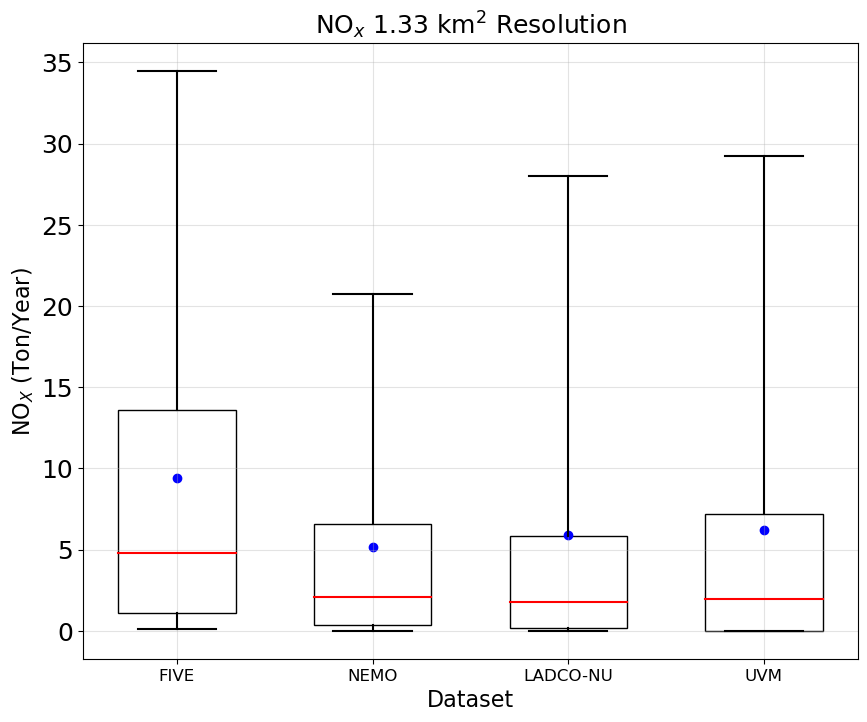

In [25]:
#################################
####### Absolute Emissions
##################################
# Combine the NOX data from all GeoDataFrames
nox_data = [cmap_five['NOX'], cmap_nemo['NOX'], cmap_ladco['NOX'], cmap_rowan['NOX']]
labels = ['FIVE', 'NEMO', 'LADCO-NU', 'UVM']

# Calculate percentiles and mean
percentiles = {label: {} for label in labels}
for data, label in zip(nox_data, labels):
    percentiles[label]['5th'] = np.percentile(data, 5)
    percentiles[label]['25th'] = np.percentile(data, 25)
    percentiles[label]['50th (median)'] = np.median(data)
    percentiles[label]['75th'] = np.percentile(data, 75)
    percentiles[label]['95th'] = np.percentile(data, 95)
    percentiles[label]['mean'] = np.mean(data)

# Print out percentiles and mean for each dataset
for label, stats in percentiles.items():
    print(f"{label} percentiles and mean:")
    for stat, value in stats.items():
        print(f"  {stat}: {value:.2f}")
    print()

# Create a custom box plot
fig, ax = plt.subplots(figsize=(10, 8))

for i, data in enumerate(nox_data, start=1):
    # Extract the required percentiles
    pct_5 = percentiles[labels[i-1]]['5th']
    pct_25 = percentiles[labels[i-1]]['25th']
    pct_50 = percentiles[labels[i-1]]['50th (median)']
    pct_75 = percentiles[labels[i-1]]['75th']
    pct_95 = percentiles[labels[i-1]]['95th']
    mean = percentiles[labels[i-1]]['mean']
    
    # Create a box plot element for each dataset
    ax.plot([i, i], [pct_5, pct_25], color='black')   # Lower whisker
    ax.plot([i, i], [pct_75, pct_95], color='black')  # Upper whisker
    ax.plot([i - 0.2, i + 0.2], [pct_5, pct_5], color='black')   # Bottom whisker cap
    ax.plot([i - 0.2, i + 0.2], [pct_95, pct_95], color='black') # Top whisker cap
    ax.add_patch(plt.Rectangle((i - 0.3, pct_25), 0.6, pct_75 - pct_25, fill=False, edgecolor='black')) # Box
    ax.plot([i - 0.3, i + 0.3], [pct_50, pct_50], color='red')  # Median line
    
    # Plot the mean
    ax.scatter(i, mean, color='blue')

# Customize the legend to include lines for median and dots for mean
median_line = plt.Line2D([], [], color='red', linestyle='-', label='Median')
mean_dot = plt.Line2D([], [], color='blue', marker='o', linestyle='None', label='Mean')

#plt.legend(handles=[median_line, mean_dot], loc='upper right', fontsize=18)

plt.xlabel('Dataset', fontsize=16)
plt.ylabel('NO$_X$ (Ton/Year)', fontsize=16)
plt.title('NO$_x$ 1.33 km$^2$ Resolution', fontsize=18)
plt.xticks(np.arange(1, len(labels) + 1), labels, fontsize=12)
plt.yticks(fontsize=18)
plt.grid(alpha=.35)
plt.show()

In [ ]:
#################################
####### Emission Flux
##################################
# Calculate NOX  for each dataset
cmap_five['NOX_'] = cmap_five['NOX'] / grid_cell_area
cmap_nemo['NOX_'] = cmap_nemo['NOX'] / grid_cell_area
cmap_ladco['NOX_'] = cmap_ladco['NOX'] / grid_cell_area
cmap_rowan['NOX_'] = cmap_rowan['NOX'] / grid_cell_area

# Combine the NOX  data from all GeoDataFrames
nox__data = [cmap_five['NOX_'], cmap_nemo['NOX_'], cmap_ladco['NOX_'], cmap_rowan['NOX_']]
labels = ['FIVE', 'NEMO', 'LADCO-NU', 'UVM']

# Calculate percentiles and mean
percentiles = {label: {} for label in labels}
for data, label in zip(nox__data, labels):
    percentiles[label]['5th'] = np.percentile(data, 5)
    percentiles[label]['25th'] = np.percentile(data, 25)
    percentiles[label]['50th (median)'] = np.median(data)
    percentiles[label]['75th'] = np.percentile(data, 75)
    percentiles[label]['95th'] = np.percentile(data, 95)
    percentiles[label]['mean'] = np.mean(data)

# Print out percentiles and mean for each dataset
for label, stats in percentiles.items():
    print(f"{label} percentiles and mean:")
    for stat, value in stats.items():
        print(f"  {stat}: {value:.2f}")
    print()

# Create a custom box plot
fig, ax = plt.subplots(figsize=(10, 8))

for i, data in enumerate(nox__data, start=1):
    # Extract the required percentiles
    pct_5 = percentiles[labels[i-1]]['5th']
    pct_25 = percentiles[labels[i-1]]['25th']
    pct_50 = percentiles[labels[i-1]]['50th (median)']
    pct_75 = percentiles[labels[i-1]]['75th']
    pct_95 = percentiles[labels[i-1]]['95th']
    mean = percentiles[labels[i-1]]['mean']
    
    # Create a box plot element for each dataset
    ax.plot([i, i], [pct_5, pct_25], color='black')   # Lower whisker
    ax.plot([i, i], [pct_75, pct_95], color='black')  # Upper whisker
    ax.plot([i - 0.2, i + 0.2], [pct_5, pct_5], color='black')   # Bottom whisker cap
    ax.plot([i - 0.2, i + 0.2], [pct_95, pct_95], color='black') # Top whisker cap
    ax.add_patch(plt.Rectangle((i - 0.3, pct_25), 0.6, pct_75 - pct_25, fill=False, edgecolor='black')) # Box
    ax.plot([i - 0.3, i + 0.3], [pct_50, pct_50], color='red')  # Median line
    
    # Plot the mean
    ax.scatter(i, mean, color='blue')

# Customize the legend to include lines for median and dots for mean
median_line = plt.Line2D([], [], color='red', linestyle='-', label='Median')
mean_dot = plt.Line2D([], [], color='blue', marker='o', linestyle='None', label='Mean')

#plt.legend(handles=[median_line, mean_dot], loc='upper right', fontsize=18)

plt.xlabel('Dataset', fontsize=16)
plt.ylabel('NO$_x$  (Ton/Year/km$^2$)', fontsize=16)
plt.title('NO$_x$  at 1.33 km$^2$ Resolution', fontsize=18)
plt.ylim(0,20)
plt.xticks(np.arange(1, len(labels) + 1), labels, fontsize=12)
plt.yticks(fontsize=18)
plt.grid(alpha=.35)
plt.show()


<h3> Calculate NOX mean of all four datasets and find difference between dataset minus mean

FIVE dataset:
  Max Difference: 50.69
  Min Difference: -55.32
  Mean NOX: 9.43
  Sum of NOX: 57241.24
  5th Percentile: -3.85
  25th Percentile: 0.05
  Median (50th Percentile): 0.89
  75th Percentile: 4.26
  95th Percentile: 15.90
  IQR: 4.22

NEMO dataset:
  Max Difference: 70.32
  Min Difference: -46.96
  Mean NOX: 5.18
  Sum of NOX: 31425.06
  5th Percentile: -8.97
  25th Percentile: -2.02
  Median (50th Percentile): -0.44
  75th Percentile: -0.02
  95th Percentile: 1.91
  IQR: 1.99

LADCO-NU dataset:
  Max Difference: 120.06
  Min Difference: -28.66
  Mean NOX: 5.92
  Sum of NOX: 35920.84
  5th Percentile: -7.38
  25th Percentile: -2.19
  Median (50th Percentile): -0.40
  75th Percentile: -0.01
  95th Percentile: 4.86
  IQR: 2.17

UVM dataset:
  Max Difference: 51.70
  Min Difference: -44.81
  Mean NOX: 6.22
  Sum of NOX: 37783.55
  5th Percentile: -6.19
  25th Percentile: -1.66
  Median (50th Percentile): -0.26
  75th Percentile: 0.23
  95th Percentile: 5.26
  IQR: 1.90



C:\Users\x12la\AppData\Local\Temp\ipykernel_2420\2326790059.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding


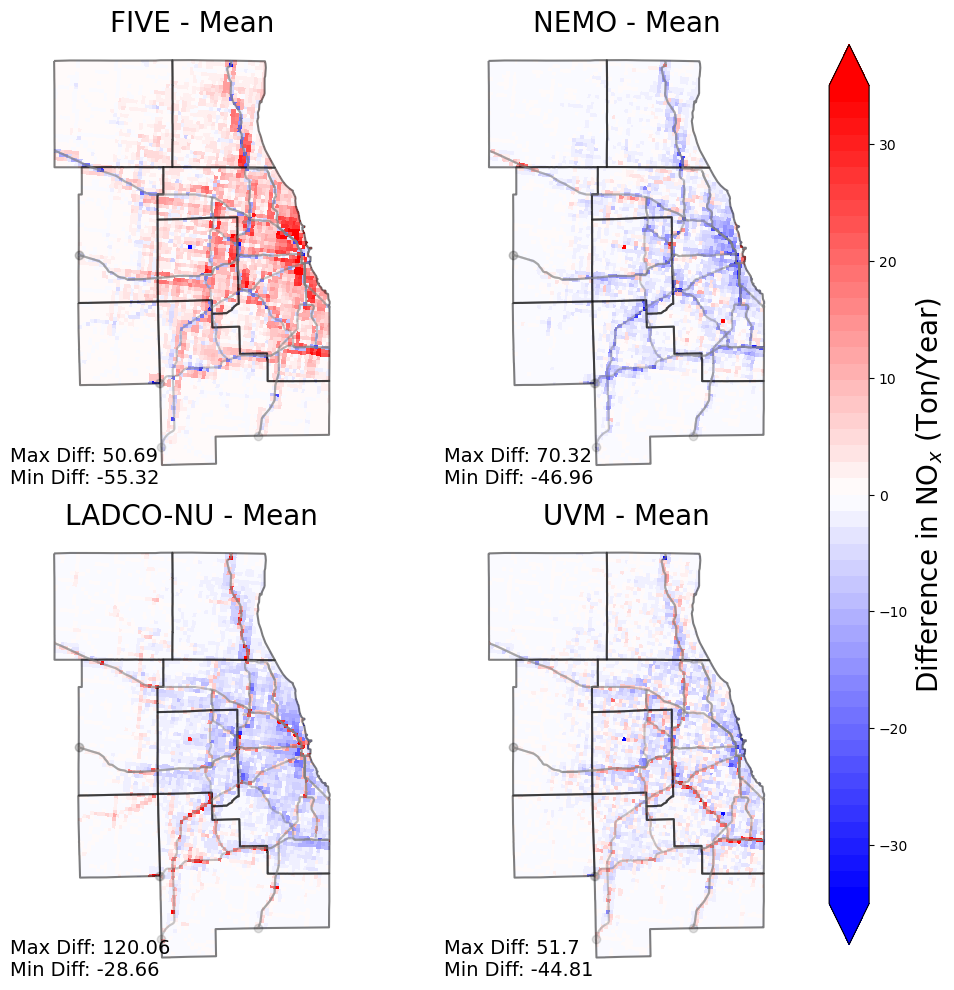

In [29]:
#################################
####### Absolute Emissions
##################################
# Create a discrete colormap based on bwr
viridis_colors = plt.cm.bwr(np.linspace(0, 1, 50))  # Get 40 evenly spaced colors from the bwr colormap
cmap_discrete = ListedColormap(viridis_colors)

# Calculate the mean of NOX for all datasets
mean_nox = (cmap_five['NOX'] + cmap_nemo['NOX'] + cmap_ladco['NOX'] + cmap_rowan['NOX']) / 4

# Calculate the difference from the mean for each dataset
cmap_five['diff_from_mean'] = cmap_five['NOX'] - mean_nox
cmap_nemo['diff_from_mean'] = cmap_nemo['NOX'] - mean_nox
cmap_ladco['diff_from_mean'] = cmap_ladco['NOX'] - mean_nox
cmap_rowan['diff_from_mean'] = cmap_rowan['NOX'] - mean_nox

# Print the maximum and minimum differences for each dataset
datasets = [('FIVE', cmap_five), ('NEMO', cmap_nemo), ('LADCO-NU', cmap_ladco), ('UVM', cmap_rowan)]
for name, cmap in datasets:
    max_diff = cmap['diff_from_mean'].max()
    min_diff = cmap['diff_from_mean'].min()
    mean_nox = cmap['NOX'].mean()
    sum_nox = cmap['NOX'].sum()

    # Calculate percentiles
    p05 = np.percentile(cmap['diff_from_mean'], 5)
    p25 = np.percentile(cmap['diff_from_mean'], 25)
    p50 = np.percentile(cmap['diff_from_mean'], 50)
    p75 = np.percentile(cmap['diff_from_mean'], 75)
    p95 = np.percentile(cmap['diff_from_mean'], 95)
    iqr = p75 - p25

    print(f"{name} dataset:")
    print(f"  Max Difference: {max_diff:.2f}")
    print(f"  Min Difference: {min_diff:.2f}")
    print(f"  Mean NOX: {mean_nox:.2f}")
    print(f"  Sum of NOX: {sum_nox:.2f}")
    print(f"  5th Percentile: {p05:.2f}")
    print(f"  25th Percentile: {p25:.2f}")
    print(f"  Median (50th Percentile): {p50:.2f}")
    print(f"  75th Percentile: {p75:.2f}")
    print(f"  95th Percentile: {p95:.2f}")
    print(f"  IQR: {iqr:.2f}")
    print()

# Create subplots with 2 rows and 2 columns and larger figsize
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plotting the difference from mean for the subplots
for i, cmap_data in enumerate([(cmap_five, 'FIVE'), (cmap_nemo, 'NEMO'), (cmap_ladco, 'LADCO-NU'), (cmap_rowan, 'UVM')]):
    row_index = i // 2  # Calculate row index
    col_index = i % 2   # Calculate column index
    cmap, label = cmap_data
    cmap.plot('diff_from_mean', ax=axs[row_index, col_index], cmap=cmap_discrete, vmin=-35, vmax=35, legend=False, antialiased=False)
    cmap_cty.boundary.plot(ax=axs[row_index, col_index], color='k', alpha=0.5)  # Add county boundaries
    cmap_roads.plot(ax=axs[row_index, col_index], color='grey', alpha=0.25)  # Add roads
    axs[row_index, col_index].set_title(f'{label} - Mean', fontsize=20)
    
    # Annotate maximum and minimum difference
    max_diff = round(cmap['diff_from_mean'].max(), 2)
    min_diff = round(cmap['diff_from_mean'].min(), 2)
    axs[row_index, col_index].annotate(f'Max Diff: {max_diff}\nMin Diff: {min_diff}',
                                       xy=(-.1, -0.005), xycoords='axes fraction',
                                       fontsize=14, ha='left', va='bottom')

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.05)  # Decrease wspace for less whitespace

# Adding a single colorbar to the right of all figures
cbar_ax = fig.add_axes([0.92, 0.05, 0.04, 0.9])  # [left, bottom, width, height]
cbar = plt.colorbar(axs[0, 0].collections[0], cax=cbar_ax, orientation='vertical', extend='both')  # Use the first subplot's collection for the
 # Use the first subplot's collection for the colorbar
cbar.set_label('Difference in NO$_x$ (Ton/Year)', fontsize=20)

# Turn off axis for all subplots
for ax in axs.flat:
    ax.set_axis_off()

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.savefig('NOX_Difference_From_Mean_2x2_discrete_colorbar1_33km.png')
plt.show()

FIVE dataset:
  Max Difference: 28.66
  Min Difference: -31.28
  Mean NOx : 5.33
  Sum of NOx : 32359.80
  5th Percentile: -2.18
  25th Percentile: 0.03
  Median (50th Percentile): 0.50
  75th Percentile: 2.41
  95th Percentile: 8.99
  IQR: 2.38

NEMO dataset:
  Max Difference: 39.75
  Min Difference: -26.55
  Mean NOx : 2.93
  Sum of NOx : 17765.31
  5th Percentile: -5.07
  25th Percentile: -1.14
  Median (50th Percentile): -0.25
  75th Percentile: -0.01
  95th Percentile: 1.08
  IQR: 1.13

LADCO-NU dataset:
  Max Difference: 67.87
  Min Difference: -16.20
  Mean NOx : 3.35
  Sum of NOx : 20306.88
  5th Percentile: -4.17
  25th Percentile: -1.24
  Median (50th Percentile): -0.23
  75th Percentile: -0.01
  95th Percentile: 2.75
  IQR: 1.23

UVM dataset:
  Max Difference: 29.23
  Min Difference: -25.33
  Mean NOx : 3.52
  Sum of NOx : 21359.91
  5th Percentile: -3.50
  25th Percentile: -0.94
  Median (50th Percentile): -0.15
  75th Percentile: 0.13
  95th Percentile: 2.97
  IQR: 1.07



C:\Users\x12la\AppData\Local\Temp\ipykernel_2420\1654968565.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding


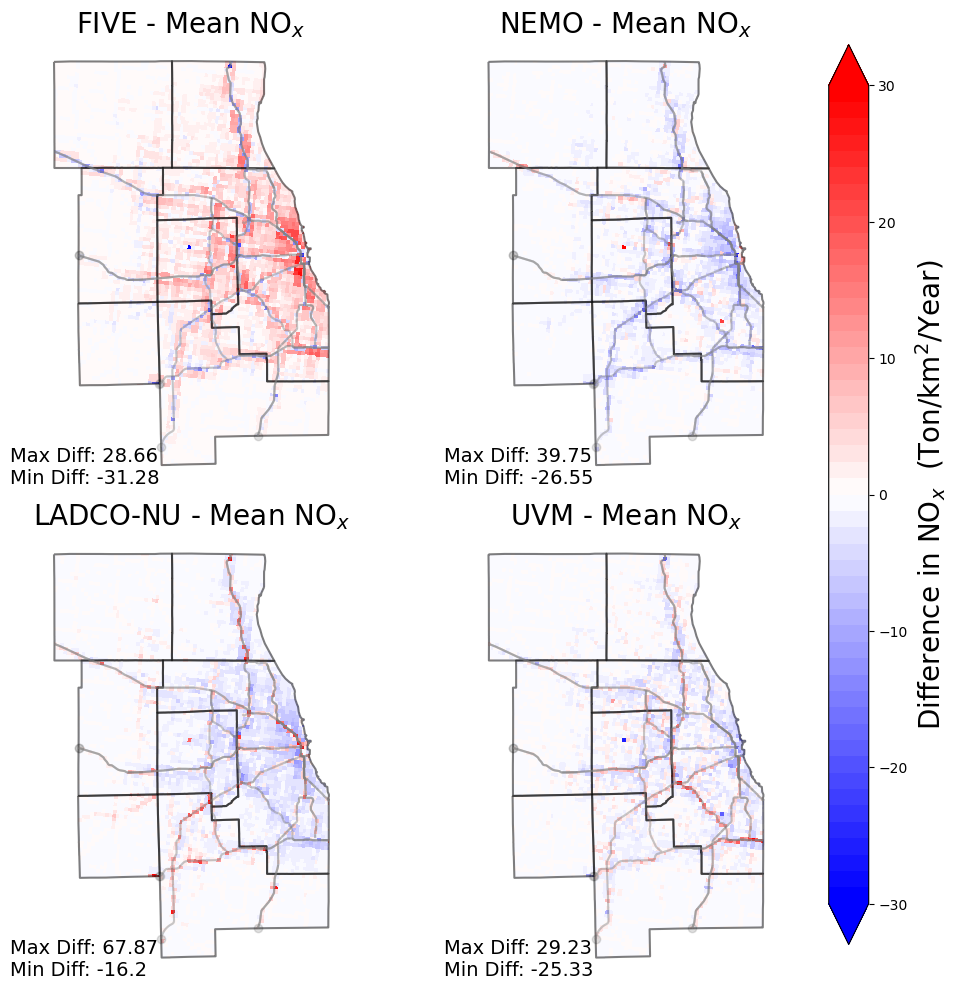

In [30]:
#################################
####### Emission Flux
##################################

# Area of a 1.33 km x 1.33 km grid cell (in km^2)
grid_cell_area = 1.33**2  # = 1.7689 km^2

# Calculate NOx  for each dataset
cmap_five['NOx_flux'] = cmap_five['NOX'] / grid_cell_area
cmap_nemo['NOx_flux'] = cmap_nemo['NOX'] / grid_cell_area
cmap_ladco['NOx_flux'] = cmap_ladco['NOX'] / grid_cell_area
cmap_rowan['NOx_flux'] = cmap_rowan['NOX'] / grid_cell_area

# Calculate the mean of NOx  for all datasets
mean_nox_ = (cmap_five['NOx_flux'] + cmap_nemo['NOx_flux'] + cmap_ladco['NOx_flux'] + cmap_rowan['NOx_flux']) / 4

# Calculate the difference from the mean for each dataset
cmap_five['diff_from_mean'] = cmap_five['NOx_flux'] - mean_nox_
cmap_nemo['diff_from_mean'] = cmap_nemo['NOx_flux'] - mean_nox_
cmap_ladco['diff_from_mean'] = cmap_ladco['NOx_flux'] - mean_nox_
cmap_rowan['diff_from_mean'] = cmap_rowan['NOx_flux'] - mean_nox_

# Print the maximum and minimum differences for each dataset
datasets = [('FIVE', cmap_five), ('NEMO', cmap_nemo), ('LADCO-NU', cmap_ladco), ('UVM', cmap_rowan)]
for name, cmap in datasets:
    max_diff = cmap['diff_from_mean'].max()
    min_diff = cmap['diff_from_mean'].min()
    mean_nox_ = cmap['NOx_flux'].mean()
    sum_nox_ = cmap['NOx_flux'].sum()

    # Calculate percentiles
    p05 = np.percentile(cmap['diff_from_mean'], 5)
    p25 = np.percentile(cmap['diff_from_mean'], 25)
    p50 = np.percentile(cmap['diff_from_mean'], 50)
    p75 = np.percentile(cmap['diff_from_mean'], 75)
    p95 = np.percentile(cmap['diff_from_mean'], 95)
    iqr = p75 - p25

    print(f"{name} dataset:")
    print(f"  Max Difference: {max_diff:.2f}")
    print(f"  Min Difference: {min_diff:.2f}")
    print(f"  Mean NOx : {mean_nox_:.2f}")
    print(f"  Sum of NOx : {sum_nox_:.2f}")
    print(f"  5th Percentile: {p05:.2f}")
    print(f"  25th Percentile: {p25:.2f}")
    print(f"  Median (50th Percentile): {p50:.2f}")
    print(f"  75th Percentile: {p75:.2f}")
    print(f"  95th Percentile: {p95:.2f}")
    print(f"  IQR: {iqr:.2f}")
    print()

# Create a discrete colormap based on bwr
bwr_colors = plt.cm.bwr(np.linspace(0, 1, 50))  # Get 50 evenly spaced colors from the bwr colormap
cmap_discrete = ListedColormap(bwr_colors)

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plotting the difference from mean for the subplots
for i, cmap_data in enumerate([(cmap_five, 'FIVE'), (cmap_nemo, 'NEMO'), (cmap_ladco, 'LADCO-NU'), (cmap_rowan, 'UVM')]):
    row_index = i // 2  # Calculate row index
    col_index = i % 2   # Calculate column index
    cmap, label = cmap_data
    cmap.plot('diff_from_mean', ax=axs[row_index, col_index], cmap=cmap_discrete, vmin=-30, vmax=30, legend=False, antialiased=False)
    cmap_cty.boundary.plot(ax=axs[row_index, col_index], color='k', alpha=0.5)  # Add county boundaries
    cmap_roads.plot(ax=axs[row_index, col_index], color='grey', alpha=0.25)  # Add roads
    axs[row_index, col_index].set_title(f'{label} - Mean NO$_x$ ', fontsize=20)
    
    # Annotate maximum and minimum difference
    max_diff = round(cmap['diff_from_mean'].max(), 2)
    min_diff = round(cmap['diff_from_mean'].min(), 2)
    axs[row_index, col_index].annotate(f'Max Diff: {max_diff}\nMin Diff: {min_diff}',
                                       xy=(-.1, -0.005), xycoords='axes fraction',
                                       fontsize=14, ha='left', va='bottom')

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.05)  # Decrease wspace for less whitespace

# Adding a single colorbar to the right of all figures
cbar_ax = fig.add_axes([0.92, 0.05, 0.04, 0.9])  # [left, bottom, width, height]
cbar = plt.colorbar(axs[0, 0].collections[0], cax=cbar_ax, orientation='vertical', extend='both')  # Use the first subplot's collection for the colorbar
cbar.set_label('Difference in NO$_x$  (Ton/km$^2$/Year)', fontsize=20)

# Turn off axis for all subplots
for ax in axs.flat:
    ax.set_axis_off()

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.savefig('NOx__Difference_From_Mean_2x2_discrete_colorbar_1_33km.png')
plt.show()  # Display figure


<h1> Simulated vehicle PM2.5 Emissions

<h3> Plot simulated emissions spatially. Calculate localized max PM25 and domain total PM25 for absolute emissions (tons/year) and emission flux (tons/km2/year). 

C:\Users\x12la\AppData\Local\Temp\ipykernel_2420\1897799193.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
C:\Users\x12la\AppData\Local\Temp\ipykernel_2420\1897799193.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


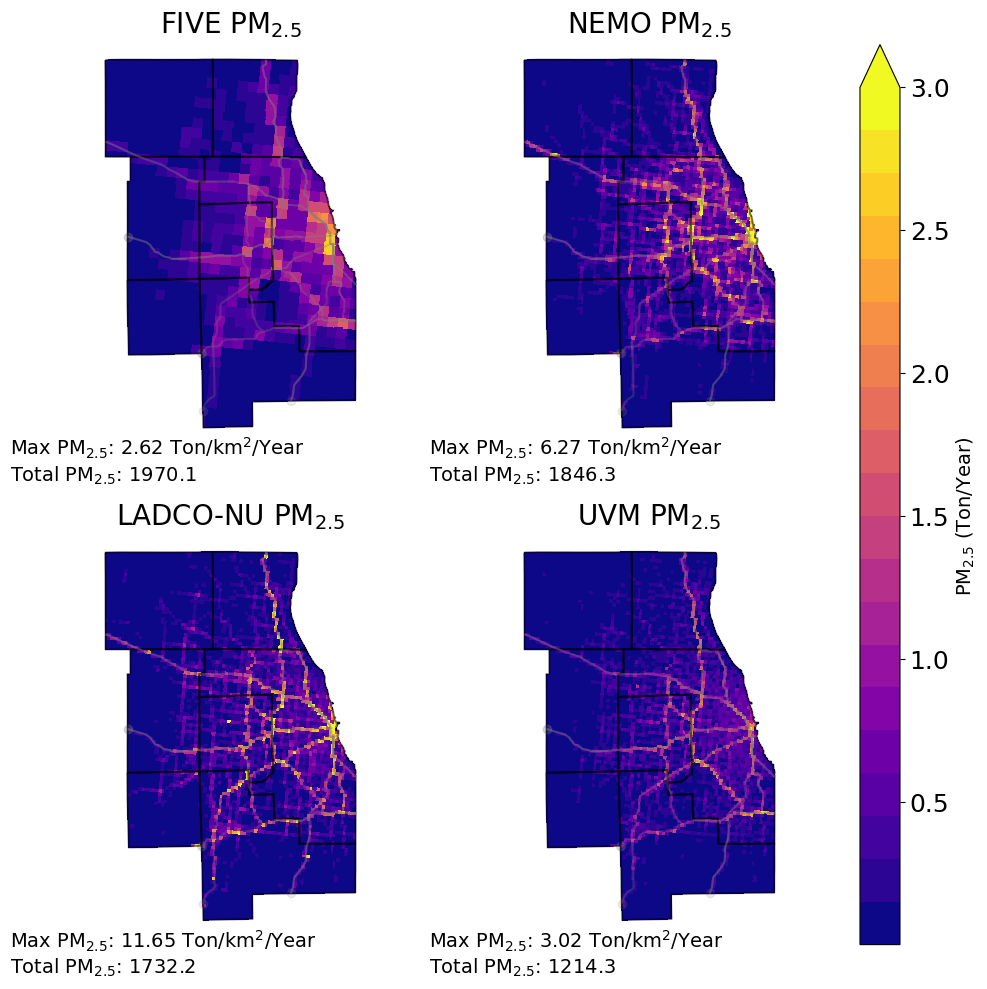

In [14]:
#################################
####### Absolute Emissions
##################################

# Create a discrete colormap based on Viridis
plasma_colors = plt.cm.plasma(np.linspace(0, 1, 20))  # Get 5 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(plasma_colors)

# Create subplots with 2 rows and 2 columns and larger figsize
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plotting PM25 figures with county boundaries and roads for the subplots
for i, cmap_data in enumerate([(cmap_five, 'FIVE'), (cmap_nemo, 'NEMO'), (cmap_ladco, 'LADCO-NU'), (cmap_rowan, 'UVM')]):
    row_index = i // 2  # Calculate row index
    col_index = i % 2   # Calculate column index
    cmap, label = cmap_data
    cmap.plot('PM25', ax=axs[row_index, col_index], vmax=3, cmap=cmap_discrete, legend=False, antialiased=False)
    cmap_cty.boundary.plot(ax=axs[row_index, col_index], color='k', alpha=0.5)  # Add county boundaries
    cmap_roads.plot(ax=axs[row_index, col_index], color='grey', alpha=0.15)  # Add roads
    axs[row_index, col_index].set_title(f'{label} PM$_{{2.5}}$', fontsize=20)
    
    # Annotate maximum PM25 and domain PM25 sum
    max_PM25 = round(cmap['PM25'].max(), 2)
    total_PM25 = round(cmap['PM25'].sum(), 1)
    axs[row_index, col_index].annotate(f'Max PM$_{{2.5}}$: {max_PM25} Ton/km$^2$/Year\nTotal PM$_{{2.5}}$: {total_PM25}',
                                       xy=(-.3, -0.1), xycoords='axes fraction',
                                       fontsize=14, ha='left', va='bottom')

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.05)  # Decrease wspace for less whitespace

# Adding a single colorbar to the right of all figures
cbar_ax = fig.add_axes([0.92, 0.05, 0.04, 0.9])  # [left, bottom, width, height]
cbar = plt.colorbar(axs[0, 0].collections[0], cax=cbar_ax, orientation='vertical', extend='max')  # Use the first subplot's collection for the colorbar
cbar.set_label('PM$_{{2.5}}$ (Ton/Year)', fontsize=14)
# Increase the tick mark label size
cbar.ax.tick_params(labelsize=18)  # Set tick label font size

# Turn off axis for all subplots
for ax in axs.flat:
    ax.set_axis_off()

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.savefig('PM25_1_33km_AllDatasets_2x2_discrete_colorbar.png')
plt.tight_layout()
plt.show()


C:\Users\x12la\AppData\Local\Temp\ipykernel_2420\999519098.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
C:\Users\x12la\AppData\Local\Temp\ipykernel_2420\999519098.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


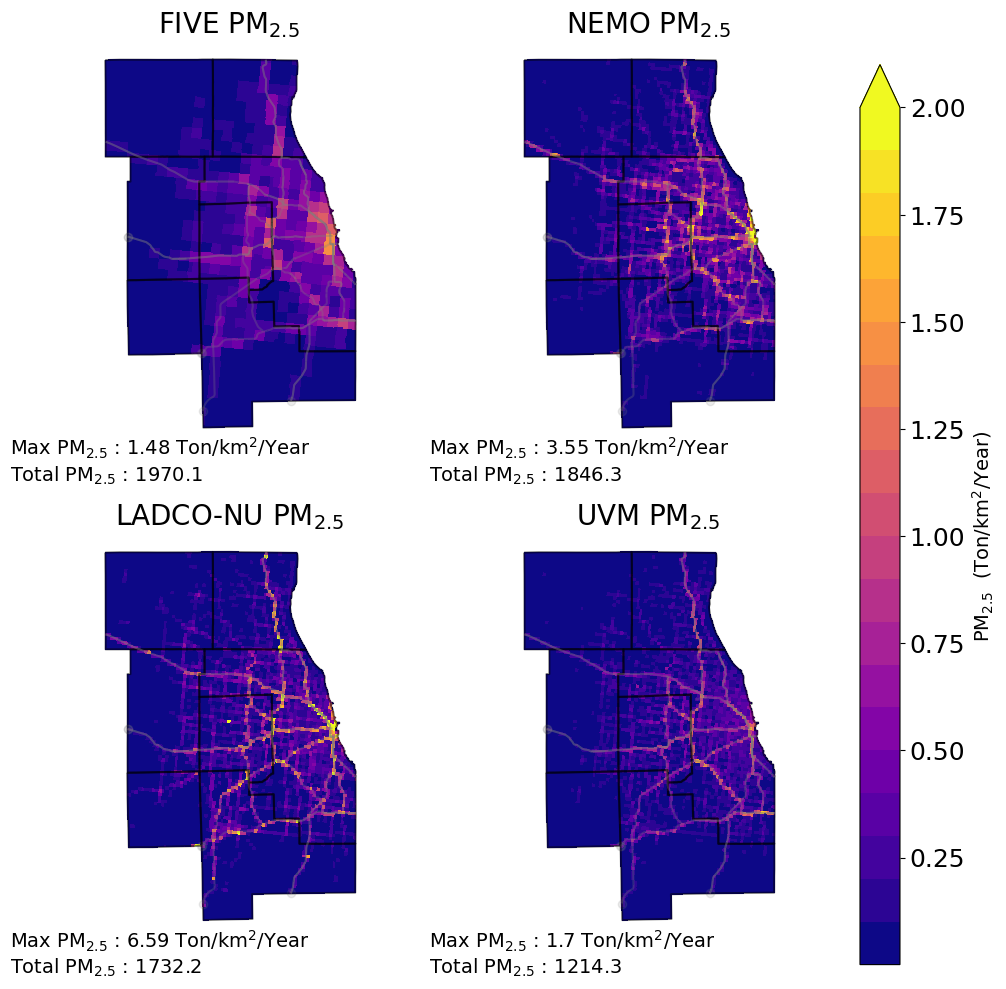

In [15]:
#################################
####### Emission Flux
##################################

# Create a discrete colormap based on Plasma
plasma_colors = plt.cm.plasma(np.linspace(0, 1, 20))  # Get 20 evenly spaced colors from Plasma colormap
cmap_discrete = ListedColormap(plasma_colors)

# Area of a 1.33 km x 1.33 km grid cell (in km^2)
grid_cell_area = 1.33**2  # = 1.7689 km^2

# Create subplots with 2 rows and 2 columns and larger figsize
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# List of datasets to be processed and plotted
datasets = [(cmap_five, 'FIVE'), (cmap_nemo, 'NEMO'), (cmap_ladco, 'LADCO-NU'), (cmap_rowan, 'UVM')]

# Process each dataset and plot PM2.5 
for i, (cmap, label) in enumerate(datasets):
    # Calculate PM2.5  (Ton/Year/km^2)
    cmap['PM25_'] = cmap['PM25'] / grid_cell_area
    
    # Determine subplot location
    row_index = i // 2  # Calculate row index
    col_index = i % 2   # Calculate column index
    
    # Plot PM2.5 
    cmap.plot('PM25_', ax=axs[row_index, col_index], vmax=2, cmap=cmap_discrete, legend=False, antialiased=False)
    
    # Plot county boundaries and roads
    cmap_cty.boundary.plot(ax=axs[row_index, col_index], color='k', alpha=0.5)  # Add county boundaries
    cmap_roads.plot(ax=axs[row_index, col_index], color='grey', alpha=0.15)  # Add roads
    
    # Set title for each subplot
    axs[row_index, col_index].set_title(f'{label} PM$_{{2.5}}$ ', fontsize=20)
    
    # Annotate maximum PM2.5  and domain PM2.5  sum
    max_PM25_ = round(cmap['PM25_'].max(), 2)
    total_PM25_ = round(cmap['PM25'].sum(), 1)
    axs[row_index, col_index].annotate(f'Max PM$_{{2.5}}$ : {max_PM25_} Ton/km$^2$/Year\nTotal PM$_{{2.5}}$ : {total_PM25_}',
                                       xy=(-.3, -0.1), xycoords='axes fraction',
                                       fontsize=14, ha='left', va='bottom')

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.05)  # Decrease wspace for less whitespace

# Adding a single colorbar to the right of all figures
cbar_ax = fig.add_axes([0.92, 0.03, 0.04, 0.9])  # [left, bottom, width, height]
cbar = plt.colorbar(axs[0, 0].collections[0], cax=cbar_ax, orientation='vertical', extend='max')  # Use the first subplot's collection for the colorbar
cbar.set_label('PM$_{{2.5}}$  (Ton/km$^2$/Year)', fontsize=14)
# Increase the tick mark label size
cbar.ax.tick_params(labelsize=18)  # Set tick label font size

# Turn off axis for all subplots
for ax in axs.flat:
    ax.set_axis_off()

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.savefig('PM25_flux_1_33km_AllDatasets_2x2_discrete_colorbar_.png')
plt.tight_layout()
plt.show()


<h3> Plot spatial correlation between datasets & calculate correlation coefficient for both absolute emissions and emission flux

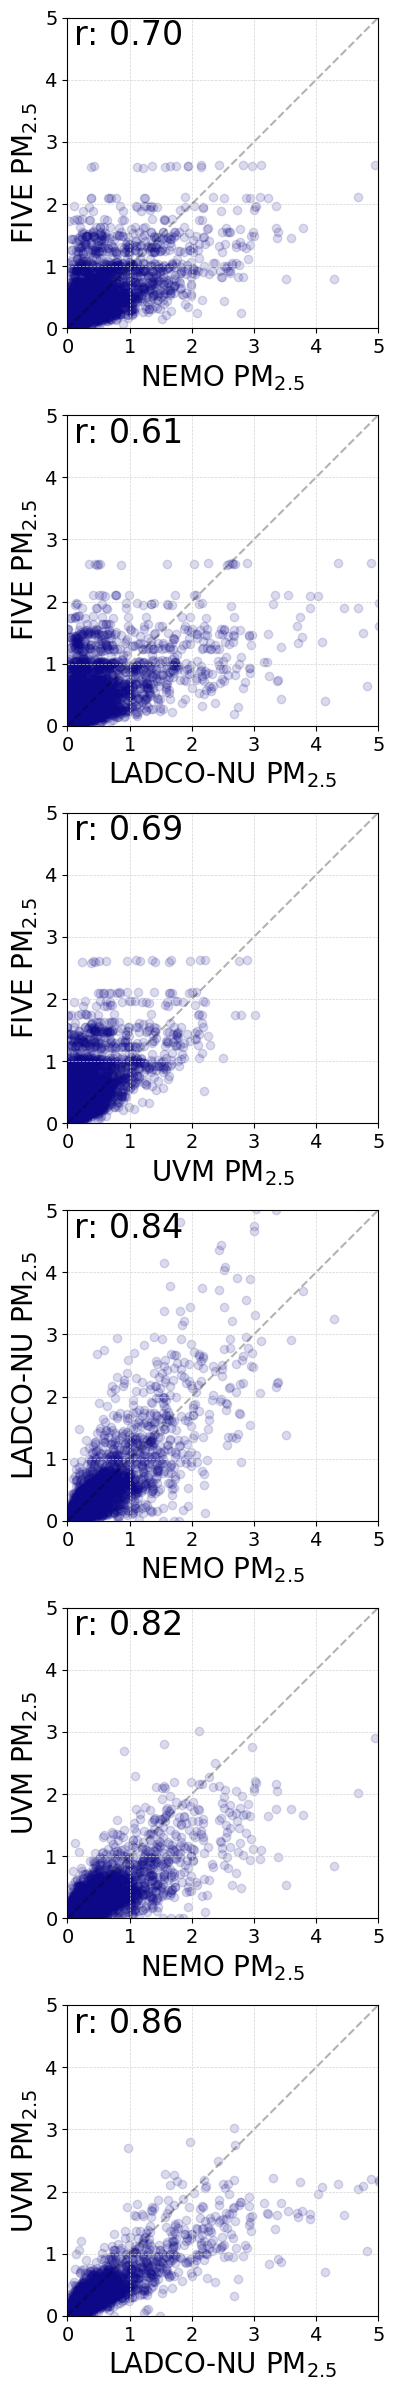

In [18]:
#################################
####### Absolute Emissions
##################################
fig = plt.figure(figsize=(12, 24))  # Set figure size

# Subplot grid layout with 5 rows
gs = fig.add_gridspec(6, 1)

# Function to plot correlation between two datasets
def plot_correlation(ax, x, y, label_x, label_y):
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    ax.scatter(x, y, color='#0D0887FF',alpha=.15)  # Scatter plot
    ax.plot([x.min(), cmap_nemo['PM25'].max()], [x.min(), cmap_nemo['PM25'].max()], c='black', linestyle="--", alpha=0.3)  # Diagonal line
    correlation_coefficient = np.corrcoef(x, y)[0, 1]  # Correlation coefficient
    ax.text(0.02, 0.91, f'r: {correlation_coefficient:.2f}', transform=ax.transAxes, fontsize=24)  # Annotation for correlation coefficient
    #ax.text(0.02, 0.82, f'Y = {np.around(model.intercept_, 5)} + {np.around(model.coef_[0], 2)}X', transform=ax.transAxes, fontsize=18, color='red')  # Annotation for linear regression equation
    ax.set_xlabel(label_x, fontsize=20)  # X label
    ax.set_ylabel(label_y, fontsize=20)  # Y label
    ax.tick_params(axis='both', which='major', labelsize=14)  # Tick parameters
    ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)  # Grid
    ax.set_aspect('equal')  # Set aspect ratio to be equal
    ax.set_xlim(0, 5)  # Set x limits
    ax.set_ylim(0, 5)  # Set y limits

# First subplot (correlation plot between NEMO and FIVE)
ax1 = fig.add_subplot(gs[0, 0])
x_nemo = np.array(cmap_nemo['PM25'])
y_five = np.array(cmap_five['PM25'])
plot_correlation(ax1, x_nemo, y_five, 'NEMO PM$_{2.5}$', 'FIVE PM$_{2.5}$')

# Second subplot (correlation plot between NU CCRG and FIVE)
ax2 = fig.add_subplot(gs[1, 0])
x_ladco = np.array(cmap_ladco['PM25'])
plot_correlation(ax2, x_ladco, y_five, 'LADCO-NU PM$_{2.5}$', 'FIVE PM$_{2.5}$')

# Third subplot (correlation plot between UVM and FIVE)
ax3 = fig.add_subplot(gs[2, 0])
x_rowan = np.array(cmap_rowan['PM25'])
plot_correlation(ax3, x_rowan, y_five, 'UVM PM$_{2.5}$', 'FIVE PM$_{2.5}$')

# Fourth subplot (correlation plot between NEMO and NU CCRG)
ax4 = fig.add_subplot(gs[3, 0])
y_nemo = np.array(cmap_nemo['PM25'])
plot_correlation(ax4, x_nemo, x_ladco, 'NEMO PM$_{2.5}$', 'LADCO-NU PM$_{2.5}$')

# Fifth subplot (correlation plot between NEMO and UVM)
ax5 = fig.add_subplot(gs[4, 0])
plot_correlation(ax5, x_nemo, x_rowan, 'NEMO PM$_{2.5}$', 'UVM PM$_{2.5}$')

# sixth subplot (correlation plot between NEMO and UVM)
ax6 = fig.add_subplot(gs[5, 0])
plot_correlation(ax6, x_ladco, x_rowan, 'LADCO-NU PM$_{2.5}$', 'UVM PM$_{2.5}$')

plt.tight_layout()  # Adjust layout
plt.savefig('PM25_Correlation_Plots_Column.png')  # Save figure
plt.show()  # Display figure


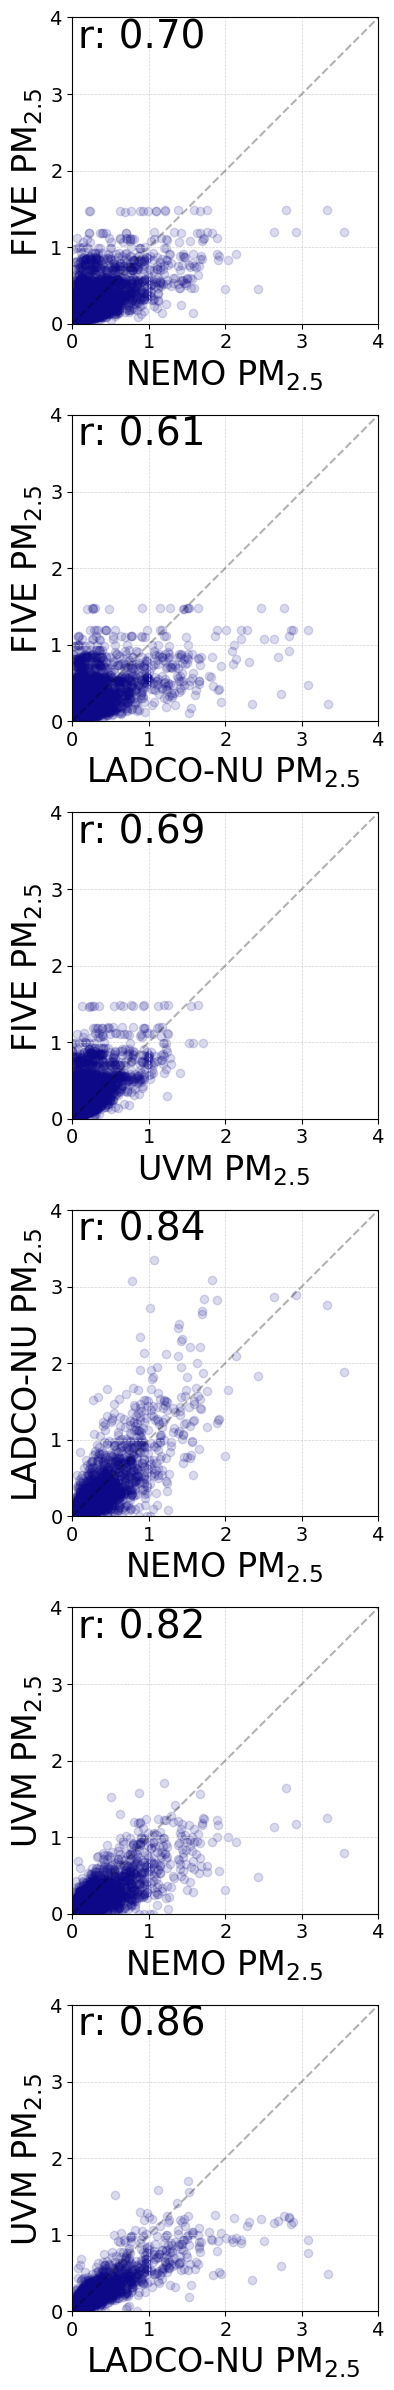

In [19]:
#################################
####### Emission Flux
##################################

# Create a discrete colormap based on Plasma
plasma_colors = plt.cm.plasma(np.linspace(0, 1, 20))  # Get 20 evenly spaced colors from Plasma colormap
cmap_discrete = ListedColormap(plasma_colors)

# Area of a 1.33 km x 1.33 km grid cell (in km^2)
grid_cell_area = 1.33**2  # = 1.7689 km^2

# Create a figure and subplot grid layout with 6 rows
fig = plt.figure(figsize=(12, 24))
gs = fig.add_gridspec(6, 1)

# Function to plot correlation between two datasets
def plot_correlation(ax, x, y, label_x, label_y):
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    ax.scatter(x, y, color='#0D0887FF', alpha=0.15)  # Scatter plot
    ax.plot([x.min(),4], [x.min(), 4], c='black', linestyle="--", alpha=0.3)  # Diagonal line
    correlation_coefficient = np.corrcoef(x, y)[0, 1]  # Correlation coefficient
    ax.text(0.02, 0.90, f'r: {correlation_coefficient:.2f}', transform=ax.transAxes, fontsize=28)  # Annotation for correlation coefficient
    #ax.text(0.02, 0.82, f'Y = {np.around(model.intercept_, 5)} + {np.around(model.coef_[0], 2)}X', transform=ax.transAxes, fontsize=18, color='red')  # Annotation for linear regression equation
    ax.set_xlabel(label_x, fontsize=24)  # X label
    ax.set_ylabel(label_y, fontsize=24)  # Y label
    ax.tick_params(axis='both', which='major', labelsize=14)  # Tick parameters
    ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)  # Grid
    ax.set_aspect('equal')  # Set aspect ratio to be equal
    ax.set_xlim(0, 4)  # Set x limits
    ax.set_ylim(0, 4)  # Set y limits

# Calculate PM2.5  for each dataset
cmap_nemo['PM25_'] = cmap_nemo['PM25'] / grid_cell_area
cmap_five['PM25_'] = cmap_five['PM25'] / grid_cell_area
cmap_ladco['PM25_'] = cmap_ladco['PM25'] / grid_cell_area
cmap_rowan['PM25_'] = cmap_rowan['PM25'] / grid_cell_area

# First subplot (correlation plot between NEMO and FIVE)
ax1 = fig.add_subplot(gs[0, 0])
x_nemo = np.array(cmap_nemo['PM25_'])
y_five = np.array(cmap_five['PM25_'])
plot_correlation(ax1, x_nemo, y_five, 'NEMO PM$_{2.5}$ ', 'FIVE PM$_{2.5}$ ')

# Second subplot (correlation plot between LADCO-NU and FIVE)
ax2 = fig.add_subplot(gs[1, 0])
x_ladco = np.array(cmap_ladco['PM25_'])
plot_correlation(ax2, x_ladco, y_five, 'LADCO-NU PM$_{2.5}$ ', 'FIVE PM$_{2.5}$ ')

# Third subplot (correlation plot between UVM and FIVE)
ax3 = fig.add_subplot(gs[2, 0])
x_rowan = np.array(cmap_rowan['PM25_'])
plot_correlation(ax3, x_rowan, y_five, 'UVM PM$_{2.5}$ ', 'FIVE PM$_{2.5}$ ')

# Fourth subplot (correlation plot between NEMO and LADCO-NU)
ax4 = fig.add_subplot(gs[3, 0])
plot_correlation(ax4, x_nemo, x_ladco, 'NEMO PM$_{2.5}$ ', 'LADCO-NU PM$_{2.5}$ ')

# Fifth subplot (correlation plot between NEMO and UVM)
ax5 = fig.add_subplot(gs[4, 0])
plot_correlation(ax5, x_nemo, x_rowan, 'NEMO PM$_{2.5}$ ', 'UVM PM$_{2.5}$ ')

# Sixth subplot (correlation plot between LADCO-NU and UVM)
ax6 = fig.add_subplot(gs[5, 0])
plot_correlation(ax6, x_ladco, x_rowan, 'LADCO-NU PM$_{2.5}$ ', 'UVM PM$_{2.5}$ ')

plt.tight_layout()  # Adjust layout
plt.savefig('PM25_flux_Correlation_Plots_Column.png')  # Save figure
plt.show()  # Display figure


<h3> Find localized grid cell maximum location

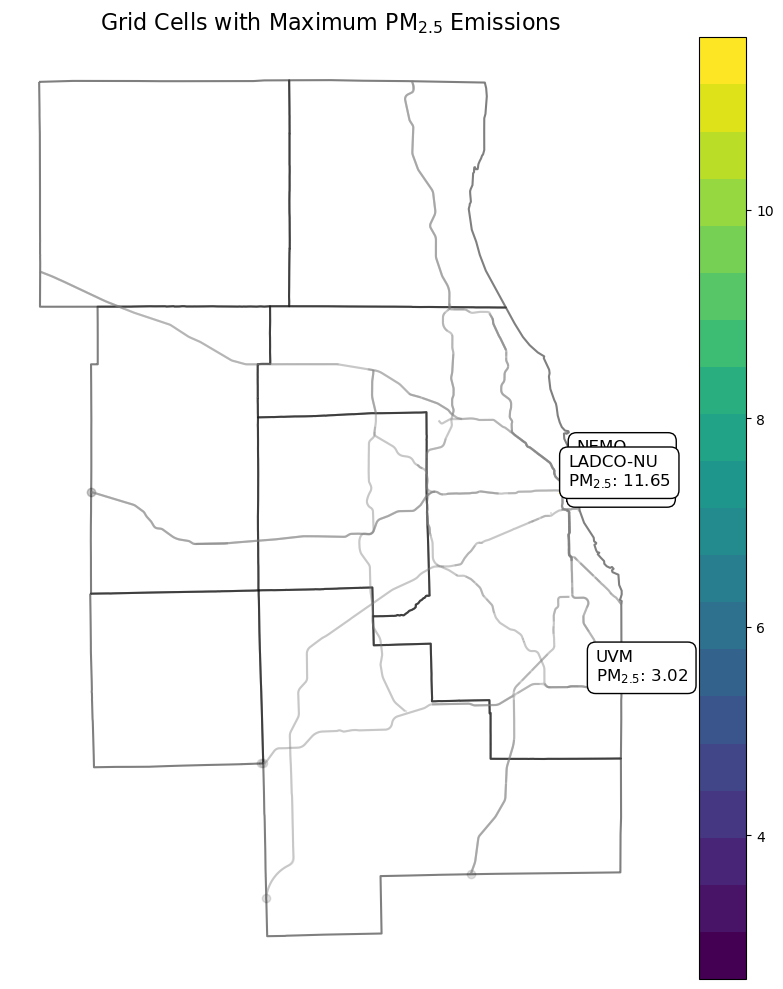

In [33]:
#################################
####### Absolute Emissions
##################################

# Create a discrete colormap based on Viridis
viridis_colors = plt.cm.viridis(np.linspace(0, 1, 20))  # Get 20 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(viridis_colors)

# Function to get the row with the maximum PM25 value
def get_max_PM25_row(gdf):
    return gdf.loc[gdf['PM25'].idxmax()]

# Get the row with the maximum PM25 value for each dataset
max_PM25_rows = [
    get_max_PM25_row(cmap_five),
    get_max_PM25_row(cmap_nemo),
    get_max_PM25_row(cmap_ladco),
    get_max_PM25_row(cmap_rowan)
]

# Create a new GeoDataFrame containing only the max PM25 rows
max_PM25_gdf = gpd.GeoDataFrame(max_PM25_rows, crs=cmap_five.crs).reset_index(drop=True)

# Create a figure and axes for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the maximum PM25 grid cells
max_PM25_gdf.plot('PM25', ax=ax, cmap=cmap_discrete, legend=True, antialiased=False)

# Add county boundaries and roads to the plot
cmap_cty.boundary.plot(ax=ax, color='k', alpha=0.5)  # Add county boundaries
cmap_roads.plot(ax=ax, color='grey', alpha=0.25)  # Add roads

# Annotate the plot with the dataset labels and PM25 values
labels = ['FIVE', 'NEMO', 'LADCO-NU', 'UVM']
for i, row in max_PM25_gdf.iterrows():
    label = labels[i]
    max_PM25 = round(row['PM25'], 2)
    ax.annotate(f'{label}\nPM$_{{2.5}}$: {max_PM25}', xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                xytext=(3, 3), textcoords='offset points', fontsize=12, color='black',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Set title and labels
ax.set_title('Grid Cells with Maximum PM$_{{2.5}}$ Emissions', fontsize=16)
ax.set_axis_off()  # Turn off axis
# Increase the tick mark label size
cbar.ax.tick_params(labelsize=18)  # Set tick label font size

# Show the plot
plt.tight_layout()
plt.show()


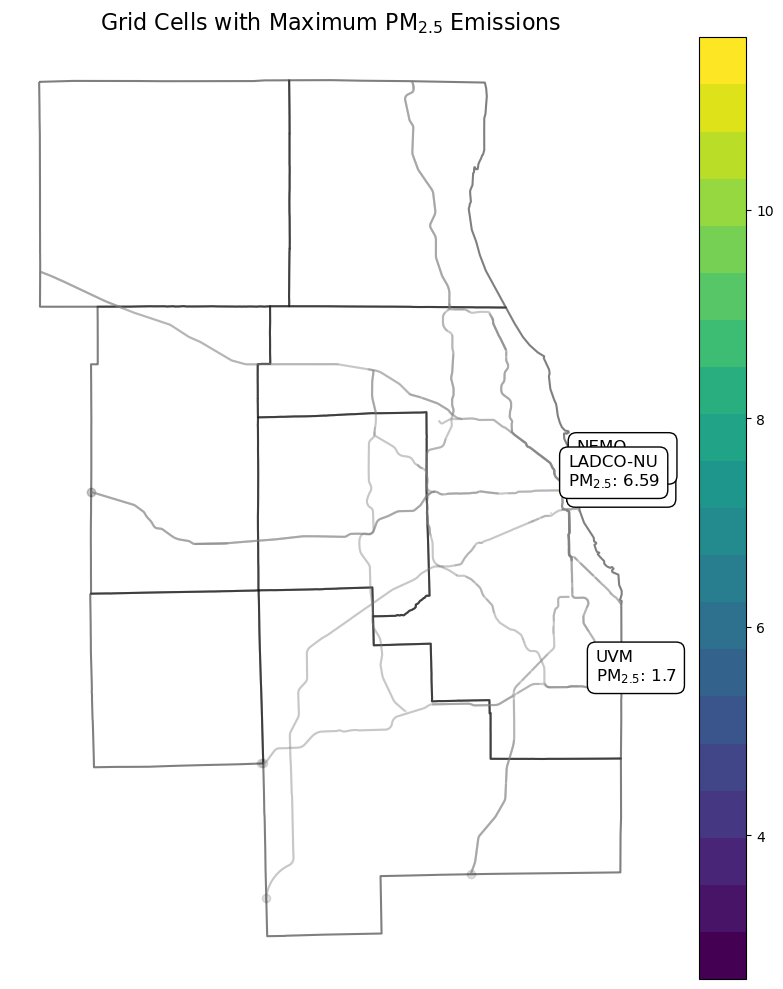

In [32]:
#################################
####### Emission Flux
##################################

# Create a discrete colormap based on Viridis
viridis_colors = plt.cm.viridis(np.linspace(0, 1, 20))  # Get 20 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(viridis_colors)

# Function to get the row with the maximum PM25 value
def get_max_PM25_row(gdf):
    return gdf.loc[(gdf['PM25']/grid_cell_area).idxmax()]

# Get the row with the maximum PM25 value for each dataset
max_PM25_rows = [
    get_max_PM25_row(cmap_five),
    get_max_PM25_row(cmap_nemo),
    get_max_PM25_row(cmap_ladco),
    get_max_PM25_row(cmap_rowan)
]

# Create a new GeoDataFrame containing only the max PM25 rows
max_PM25_gdf = gpd.GeoDataFrame(max_PM25_rows, crs=cmap_five.crs).reset_index(drop=True)

# Create a figure and axes for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the maximum PM25 grid cells
max_PM25_gdf.plot('PM25', ax=ax, cmap=cmap_discrete, legend=True, antialiased=False)

# Add county boundaries and roads to the plot
cmap_cty.boundary.plot(ax=ax, color='k', alpha=0.5)  # Add county boundaries
cmap_roads.plot(ax=ax, color='grey', alpha=0.25)  # Add roads

# Annotate the plot with the dataset labels and PM25 values
labels = ['FIVE', 'NEMO', 'LADCO-NU', 'UVM']
for i, row in max_PM25_gdf.iterrows():
    label = labels[i]
    max_PM25 = round(row['PM25']/grid_cell_area, 2)
    ax.annotate(f'{label}\nPM$_{{2.5}}$: {max_PM25}', xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                xytext=(3, 3), textcoords='offset points', fontsize=12, color='black',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Set title and labels
ax.set_title('Grid Cells with Maximum PM$_{{2.5}}$ Emissions', fontsize=16)
ax.set_axis_off()  # Turn off axis
# Increase the tick mark label size
cbar.ax.tick_params(labelsize=18)  # Set tick label font size

# Show the plot
plt.tight_layout()
plt.show()


<h3> PM2.5 Box and whisker plots

FIVE percentiles and mean:
  5th: 0.01
  25th: 0.04
  50th (median): 0.16
  75th: 0.46
  95th: 1.24
  mean: 0.32

NEMO percentiles and mean:
  5th: 0.00
  25th: 0.02
  50th (median): 0.11
  75th: 0.38
  95th: 1.32
  mean: 0.30

LADCO-NU percentiles and mean:
  5th: 0.00
  25th: 0.01
  50th (median): 0.10
  75th: 0.32
  95th: 1.24
  mean: 0.29

UVM percentiles and mean:
  5th: 0.00
  25th: 0.00
  50th (median): 0.07
  75th: 0.26
  95th: 0.85
  mean: 0.20



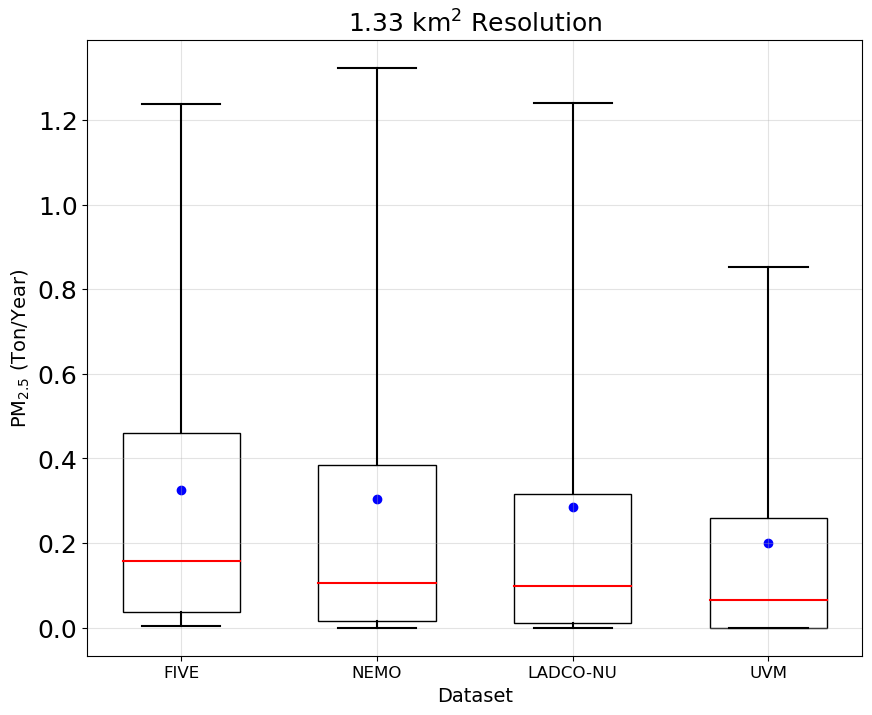

In [35]:
#################################
####### Absolute Emissions
##################################

# Combine the PM25 data from all GeoDataFrames
PM25_data = [cmap_five['PM25'], cmap_nemo['PM25'], cmap_ladco['PM25'], cmap_rowan['PM25']]
labels = ['FIVE', 'NEMO', 'LADCO-NU', 'UVM']

# Calculate percentiles and mean
percentiles = {label: {} for label in labels}
for data, label in zip(PM25_data, labels):
    percentiles[label]['5th'] = np.percentile(data, 5)
    percentiles[label]['25th'] = np.percentile(data, 25)
    percentiles[label]['50th (median)'] = np.median(data)
    percentiles[label]['75th'] = np.percentile(data, 75)
    percentiles[label]['95th'] = np.percentile(data, 95)
    percentiles[label]['mean'] = np.mean(data)

# Print out percentiles and mean for each dataset
for label, stats in percentiles.items():
    print(f"{label} percentiles and mean:")
    for stat, value in stats.items():
        print(f"  {stat}: {value:.2f}")
    print()

# Create a custom box plot
fig, ax = plt.subplots(figsize=(10, 8))

for i, data in enumerate(PM25_data, start=1):
    # Extract the required percentiles
    pct_5 = percentiles[labels[i-1]]['5th']
    pct_25 = percentiles[labels[i-1]]['25th']
    pct_50 = percentiles[labels[i-1]]['50th (median)']
    pct_75 = percentiles[labels[i-1]]['75th']
    pct_95 = percentiles[labels[i-1]]['95th']
    mean = percentiles[labels[i-1]]['mean']
    
    # Create a box plot element for each dataset
    ax.plot([i, i], [pct_5, pct_25], color='black')   # Lower whisker
    ax.plot([i, i], [pct_75, pct_95], color='black')  # Upper whisker
    ax.plot([i - 0.2, i + 0.2], [pct_5, pct_5], color='black')   # Bottom whisker cap
    ax.plot([i - 0.2, i + 0.2], [pct_95, pct_95], color='black') # Top whisker cap
    ax.add_patch(plt.Rectangle((i - 0.3, pct_25), 0.6, pct_75 - pct_25, fill=False, edgecolor='black')) # Box
    ax.plot([i - 0.3, i + 0.3], [pct_50, pct_50], color='red')  # Median line
    
    # Plot the mean
    ax.scatter(i, mean, color='blue')

# Customize the legend to include lines for median and dots for mean
median_line = plt.Line2D([], [], color='red', linestyle='-', label='Median')
mean_dot = plt.Line2D([], [], color='blue', marker='o', linestyle='None', label='Mean')

#plt.legend(handles=[median_line, mean_dot], loc='upper right', fontsize=18)

plt.xlabel('Dataset', fontsize=14)
plt.ylabel('PM$_{{2.5}}$ (Ton/Year)', fontsize=14)
plt.title('1.33 km$^2$ Resolution', fontsize=18)
plt.xticks(np.arange(1, len(labels) + 1), labels, fontsize=12)
plt.yticks(fontsize=18)
plt.grid(alpha=.35)
plt.show()


FIVE percentiles and mean:
  5th: 0.00
  25th: 0.02
  50th (median): 0.09
  75th: 0.26
  95th: 0.70
  mean: 0.18

NEMO percentiles and mean:
  5th: 0.00
  25th: 0.01
  50th (median): 0.06
  75th: 0.22
  95th: 0.75
  mean: 0.17

LADCO-NU percentiles and mean:
  5th: 0.00
  25th: 0.01
  50th (median): 0.06
  75th: 0.18
  95th: 0.70
  mean: 0.16

UVM percentiles and mean:
  5th: 0.00
  25th: 0.00
  50th (median): 0.04
  75th: 0.15
  95th: 0.48
  mean: 0.11



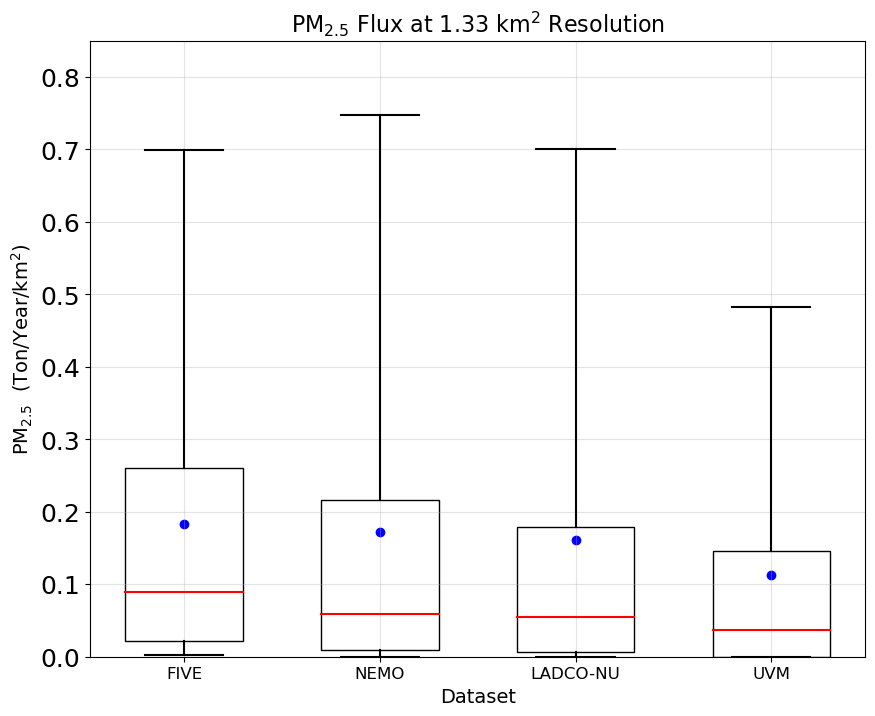

In [36]:
#################################
####### Emission Flux
##################################

# Calculate PM2.5  for each dataset (Ton/Year/km²)
cmap_five['PM25_flux'] = cmap_five['PM25'] / 1.33**2
cmap_nemo['PM25_flux'] = cmap_nemo['PM25'] / 1.33**2
cmap_ladco['PM25_flux'] = cmap_ladco['PM25'] / 1.33**2
cmap_rowan['PM25_flux'] = cmap_rowan['PM25'] / 1.33**2

# Combine the PM25_ data from all GeoDataFrames
PM25__data = [cmap_five['PM25_flux'], cmap_nemo['PM25_flux'], cmap_ladco['PM25_flux'], cmap_rowan['PM25_flux']]
labels = ['FIVE', 'NEMO', 'LADCO-NU', 'UVM']

# Calculate percentiles and mean
percentiles = {label: {} for label in labels}
for data, label in zip(PM25__data, labels):
    percentiles[label]['5th'] = np.percentile(data, 5)
    percentiles[label]['25th'] = np.percentile(data, 25)
    percentiles[label]['50th (median)'] = np.median(data)
    percentiles[label]['75th'] = np.percentile(data, 75)
    percentiles[label]['95th'] = np.percentile(data, 95)
    percentiles[label]['mean'] = np.mean(data)

# Print out percentiles and mean for each dataset
for label, stats in percentiles.items():
    print(f"{label} percentiles and mean:")
    for stat, value in stats.items():
        print(f"  {stat}: {value:.2f}")
    print()

# Create a custom box plot
fig, ax = plt.subplots(figsize=(10, 8))

for i, data in enumerate(PM25__data, start=1):
    # Extract the required percentiles
    pct_5 = percentiles[labels[i-1]]['5th']
    pct_25 = percentiles[labels[i-1]]['25th']
    pct_50 = percentiles[labels[i-1]]['50th (median)']
    pct_75 = percentiles[labels[i-1]]['75th']
    pct_95 = percentiles[labels[i-1]]['95th']
    mean = percentiles[labels[i-1]]['mean']
    
    # Create a box plot element for each dataset
    ax.plot([i, i], [pct_5, pct_25], color='black')   # Lower whisker
    ax.plot([i, i], [pct_75, pct_95], color='black')  # Upper whisker
    ax.plot([i - 0.2, i + 0.2], [pct_5, pct_5], color='black')   # Bottom whisker cap
    ax.plot([i - 0.2, i + 0.2], [pct_95, pct_95], color='black') # Top whisker cap
    ax.add_patch(plt.Rectangle((i - 0.3, pct_25), 0.6, pct_75 - pct_25, fill=False, edgecolor='black')) # Box
    ax.plot([i - 0.3, i + 0.3], [pct_50, pct_50], color='red')  # Median line
    
    # Plot the mean
    ax.scatter(i, mean, color='blue')

# Customize the legend to include lines for median and dots for mean
median_line = plt.Line2D([], [], color='red', linestyle='-', label='Median')
mean_dot = plt.Line2D([], [], color='blue', marker='o', linestyle='None', label='Mean')

#plt.legend(handles=[median_line, mean_dot], loc='upper right', fontsize=18)

plt.xlabel('Dataset', fontsize=14)
plt.ylabel('PM$_{2.5}$  (Ton/Year/km$^2$)', fontsize=14)
plt.title('PM$_{2.5}$ Flux at 1.33 km$^2$ Resolution', fontsize=16)
plt.xticks(np.arange(1, len(labels) + 1), labels, fontsize=12)
plt.yticks(fontsize=18)
plt.ylim(0,.85)
plt.grid(alpha=.35)
plt.show()


<h3> Calculate PM2.5 mean of all four datasets and find difference between dataset minus mean

FIVE dataset:
  Max Difference: 1.71
  Min Difference: -2.91
  Mean PM25: 0.32
  Sum of PM25: 1970.09
  5th Percentile: -0.28
  25th Percentile: -0.02
  Median (50th Percentile): 0.01
  75th Percentile: 0.10
  95th Percentile: 0.47
  IQR: 0.12

NEMO dataset:
  Max Difference: 3.00
  Min Difference: -0.87
  Mean PM25: 0.30
  Sum of PM25: 1846.25
  5th Percentile: -0.17
  25th Percentile: -0.03
  Median (50th Percentile): -0.00
  75th Percentile: 0.03
  95th Percentile: 0.34
  IQR: 0.06

LADCO-NU dataset:
  Max Difference: 6.13
  Min Difference: -0.98
  Mean PM25: 0.29
  Sum of PM25: 1732.19
  5th Percentile: -0.23
  25th Percentile: -0.05
  Median (50th Percentile): -0.01
  75th Percentile: 0.02
  95th Percentile: 0.29
  IQR: 0.07

UVM dataset:
  Max Difference: 1.11
  Min Difference: -2.63
  Mean PM25: 0.20
  Sum of PM25: 1214.27
  5th Percentile: -0.36
  25th Percentile: -0.11
  Median (50th Percentile): -0.03
  75th Percentile: -0.00
  95th Percentile: 0.05
  IQR: 0.11



C:\Users\x12la\AppData\Local\Temp\ipykernel_2420\2973503320.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding


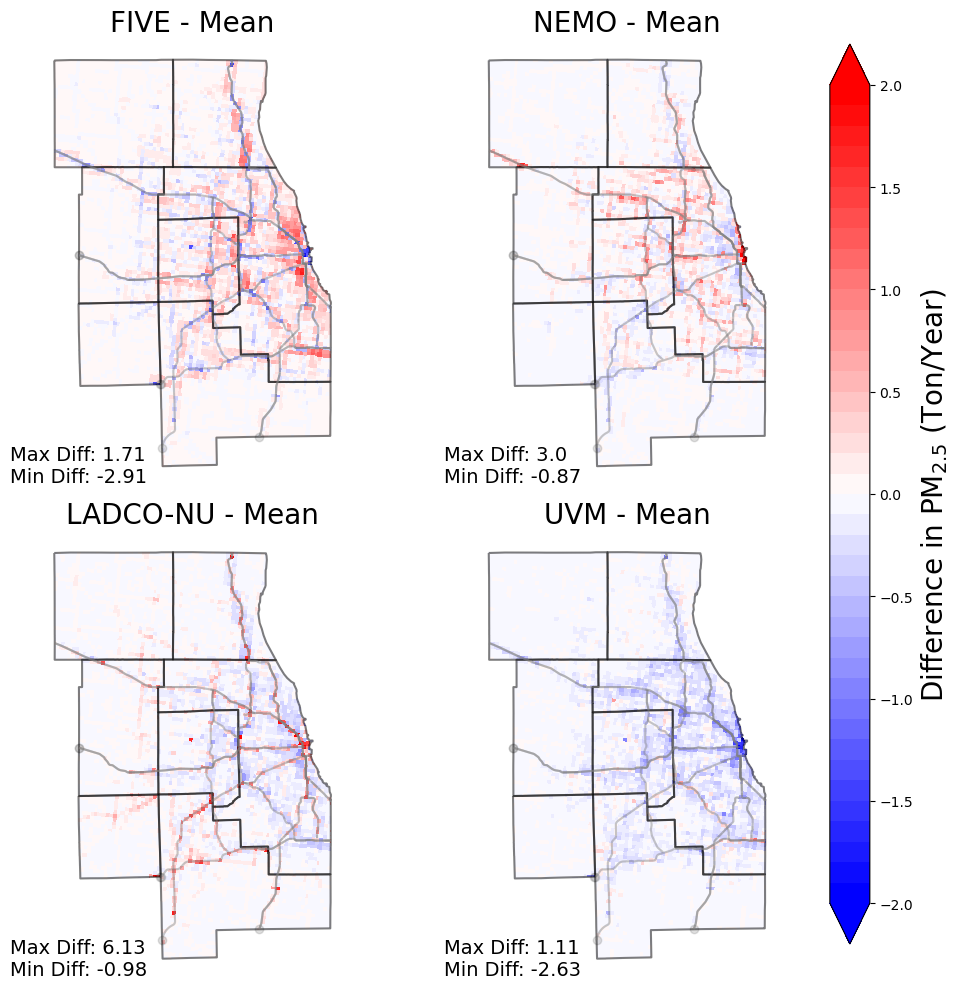

In [37]:
#################################
####### Absolute Emissions
##################################

# Create a discrete colormap based on bwr
viridis_colors = plt.cm.bwr(np.linspace(0, 1, 40))  # Get 40 evenly spaced colors from the bwr colormap
cmap_discrete = ListedColormap(viridis_colors)

# Calculate the mean of PM25 for all datasets
mean_PM25 = (cmap_five['PM25'] + cmap_nemo['PM25'] + cmap_ladco['PM25'] + cmap_rowan['PM25']) / 4

# Calculate the difference from the mean for each dataset
cmap_five['diff_from_mean'] = cmap_five['PM25'] - mean_PM25
cmap_nemo['diff_from_mean'] = cmap_nemo['PM25'] - mean_PM25
cmap_ladco['diff_from_mean'] = cmap_ladco['PM25'] - mean_PM25
cmap_rowan['diff_from_mean'] = cmap_rowan['PM25'] - mean_PM25

# Print the maximum and minimum differences for each dataset
datasets = [('FIVE', cmap_five), ('NEMO', cmap_nemo), ('LADCO-NU', cmap_ladco), ('UVM', cmap_rowan)]
for name, cmap in datasets:
    max_diff = cmap['diff_from_mean'].max()
    min_diff = cmap['diff_from_mean'].min()
    mean_PM25 = cmap['PM25'].mean()
    sum_PM25 = cmap['PM25'].sum()

    # Calculate percentiles
    p05 = np.percentile(cmap['diff_from_mean'], 5)
    p25 = np.percentile(cmap['diff_from_mean'], 25)
    p50 = np.percentile(cmap['diff_from_mean'], 50)
    p75 = np.percentile(cmap['diff_from_mean'], 75)
    p95 = np.percentile(cmap['diff_from_mean'], 95)
    iqr = p75 - p25

    print(f"{name} dataset:")
    print(f"  Max Difference: {max_diff:.2f}")
    print(f"  Min Difference: {min_diff:.2f}")
    print(f"  Mean PM25: {mean_PM25:.2f}")
    print(f"  Sum of PM25: {sum_PM25:.2f}")
    print(f"  5th Percentile: {p05:.2f}")
    print(f"  25th Percentile: {p25:.2f}")
    print(f"  Median (50th Percentile): {p50:.2f}")
    print(f"  75th Percentile: {p75:.2f}")
    print(f"  95th Percentile: {p95:.2f}")
    print(f"  IQR: {iqr:.2f}")
    print()

# Create subplots with 2 rows and 2 columns and larger figsize
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plotting the difference from mean for the subplots
for i, cmap_data in enumerate([(cmap_five, 'FIVE'), (cmap_nemo, 'NEMO'), (cmap_ladco, 'LADCO-NU'), (cmap_rowan, 'UVM')]):
    row_index = i // 2  # Calculate row index
    col_index = i % 2   # Calculate column index
    cmap, label = cmap_data
    cmap.plot('diff_from_mean', ax=axs[row_index, col_index], cmap=cmap_discrete, vmin=-2, vmax=2, legend=False, antialiased=False)
    cmap_cty.boundary.plot(ax=axs[row_index, col_index], color='k', alpha=0.5)  # Add county boundaries
    cmap_roads.plot(ax=axs[row_index, col_index], color='grey', alpha=0.25)  # Add roads
    axs[row_index, col_index].set_title(f'{label} - Mean', fontsize=20)
    
    # Annotate maximum and minimum difference
    max_diff = round(cmap['diff_from_mean'].max(), 2)
    min_diff = round(cmap['diff_from_mean'].min(), 2)
    axs[row_index, col_index].annotate(f'Max Diff: {max_diff}\nMin Diff: {min_diff}',
                                       xy=(-.1, 0), xycoords='axes fraction',
                                       fontsize=14, ha='left', va='bottom')

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.05)  # Decrease wspace for less whitespace

# Adding a single colorbar to the right of all figures
cbar_ax = fig.add_axes([0.92, 0.05, 0.04, 0.9])  # [left, bottom, width, height]
cbar = plt.colorbar(axs[0, 0].collections[0], cax=cbar_ax, orientation='vertical', extend='both')  # Use the first subplot's collection for the
 # Use the first subplot's collection for the colorbar
cbar.set_label('Difference in PM$_{{2.5}}$ (Ton/Year)', fontsize=20)

# Turn off axis for all subplots
for ax in axs.flat:
    ax.set_axis_off()

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.savefig('PM25_Difference_From_Mean_2x2_discrete_colorbar1_33km.png')
plt.show()


FIVE dataset:
  Max Difference: 0.97
  Min Difference: -1.64
  Mean PM2.5 : 0.18
  Sum of PM2.5 : 1113.74
  5th Percentile: -0.16
  25th Percentile: -0.01
  Median (50th Percentile): 0.01
  75th Percentile: 0.06
  95th Percentile: 0.26
  IQR: 0.07

NEMO dataset:
  Max Difference: 1.69
  Min Difference: -0.49
  Mean PM2.5 : 0.17
  Sum of PM2.5 : 1043.73
  5th Percentile: -0.10
  25th Percentile: -0.02
  Median (50th Percentile): -0.00
  75th Percentile: 0.02
  95th Percentile: 0.19
  IQR: 0.04

LADCO-NU dataset:
  Max Difference: 3.46
  Min Difference: -0.55
  Mean PM2.5 : 0.16
  Sum of PM2.5 : 979.25
  5th Percentile: -0.13
  25th Percentile: -0.03
  Median (50th Percentile): -0.00
  75th Percentile: 0.01
  95th Percentile: 0.16
  IQR: 0.04

UVM dataset:
  Max Difference: 0.63
  Min Difference: -1.49
  Mean PM2.5 : 0.11
  Sum of PM2.5 : 686.45
  5th Percentile: -0.20
  25th Percentile: -0.06
  Median (50th Percentile): -0.02
  75th Percentile: -0.00
  95th Percentile: 0.03
  IQR: 0.06


C:\Users\x12la\AppData\Local\Temp\ipykernel_2420\824208828.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding


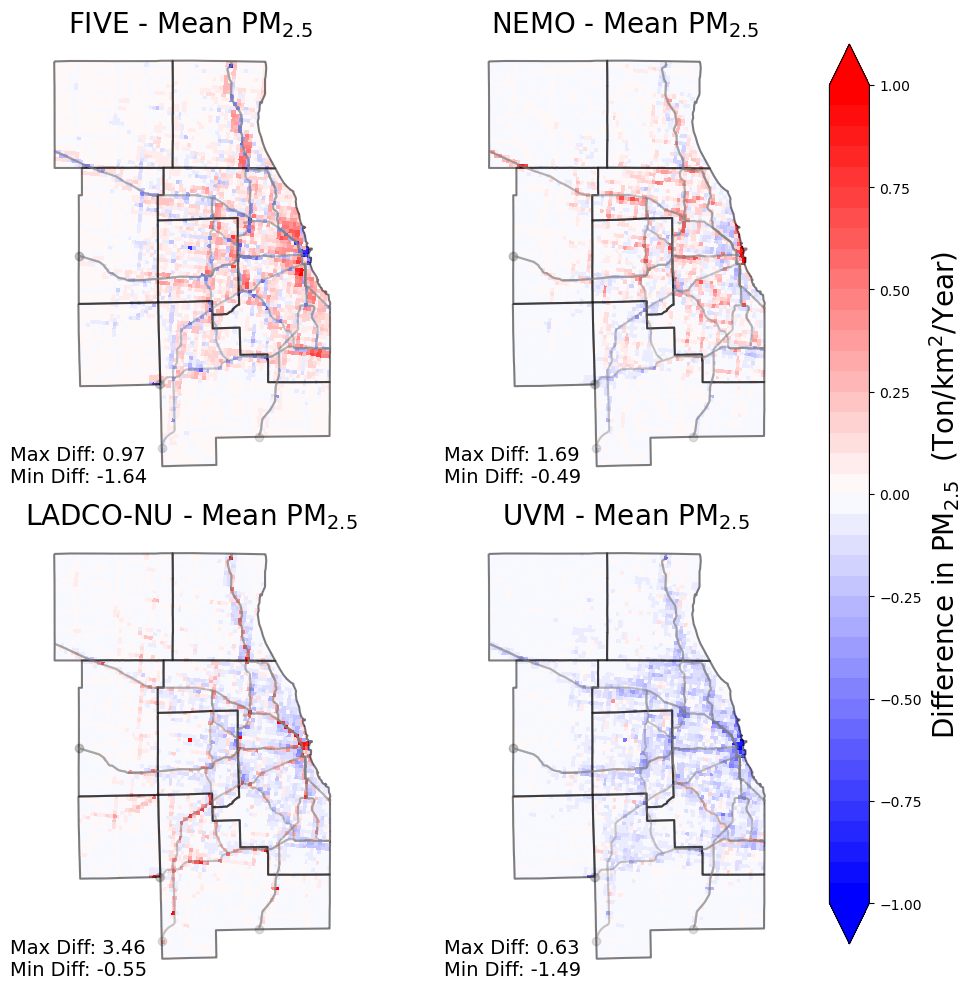

In [38]:
#################################
####### Emission Flux
##################################

# Calculate PM2.5  for each dataset
cmap_five['PM25_flux'] = cmap_five['PM25'] / grid_cell_area
cmap_nemo['PM25_flux'] = cmap_nemo['PM25'] / grid_cell_area
cmap_ladco['PM25_flux'] = cmap_ladco['PM25'] / grid_cell_area
cmap_rowan['PM25_flux'] = cmap_rowan['PM25'] / grid_cell_area

# Calculate the mean of PM2.5  for all datasets
mean_PM25_ = (cmap_five['PM25_flux'] + cmap_nemo['PM25_flux'] + cmap_ladco['PM25_flux'] + cmap_rowan['PM25_flux']) / 4

# Calculate the difference from the mean for each dataset
cmap_five['diff_from_mean'] = cmap_five['PM25_flux'] - mean_PM25_
cmap_nemo['diff_from_mean'] = cmap_nemo['PM25_flux'] - mean_PM25_
cmap_ladco['diff_from_mean'] = cmap_ladco['PM25_flux'] - mean_PM25_
cmap_rowan['diff_from_mean'] = cmap_rowan['PM25_flux'] - mean_PM25_

# Print the maximum and minimum differences for each dataset
datasets = [('FIVE', cmap_five), ('NEMO', cmap_nemo), ('LADCO-NU', cmap_ladco), ('UVM', cmap_rowan)]
for name, cmap in datasets:
    max_diff = cmap['diff_from_mean'].max()
    min_diff = cmap['diff_from_mean'].min()
    mean_PM25_ = cmap['PM25_flux'].mean()
    sum_PM25_ = cmap['PM25_flux'].sum()

    # Calculate percentiles
    p05 = np.percentile(cmap['diff_from_mean'], 5)
    p25 = np.percentile(cmap['diff_from_mean'], 25)
    p50 = np.percentile(cmap['diff_from_mean'], 50)
    p75 = np.percentile(cmap['diff_from_mean'], 75)
    p95 = np.percentile(cmap['diff_from_mean'], 95)
    iqr = p75 - p25

    print(f"{name} dataset:")
    print(f"  Max Difference: {max_diff:.2f}")
    print(f"  Min Difference: {min_diff:.2f}")
    print(f"  Mean PM2.5 : {mean_PM25_:.2f}")
    print(f"  Sum of PM2.5 : {sum_PM25_:.2f}")
    print(f"  5th Percentile: {p05:.2f}")
    print(f"  25th Percentile: {p25:.2f}")
    print(f"  Median (50th Percentile): {p50:.2f}")
    print(f"  75th Percentile: {p75:.2f}")
    print(f"  95th Percentile: {p95:.2f}")
    print(f"  IQR: {iqr:.2f}")
    print()

# Create a discrete colormap based on bwr
bwr_colors = plt.cm.bwr(np.linspace(0, 1, 40))  # Get 40 evenly spaced colors from the bwr colormap
cmap_discrete = ListedColormap(bwr_colors)

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plotting the difference from mean for the subplots
for i, cmap_data in enumerate([(cmap_five, 'FIVE'), (cmap_nemo, 'NEMO'), (cmap_ladco, 'LADCO-NU'), (cmap_rowan, 'UVM')]):
    row_index = i // 2  # Calculate row index
    col_index = i % 2   # Calculate column index
    cmap, label = cmap_data
    cmap.plot('diff_from_mean', ax=axs[row_index, col_index], cmap=cmap_discrete, vmin=-1, vmax=1, legend=False, antialiased=False)
    cmap_cty.boundary.plot(ax=axs[row_index, col_index], color='k', alpha=0.5)  # Add county boundaries
    cmap_roads.plot(ax=axs[row_index, col_index], color='grey', alpha=0.25)  # Add roads
    axs[row_index, col_index].set_title(f'{label} - Mean PM$_{{2.5}}$ ', fontsize=20)
    
    # Annotate maximum and minimum difference
    max_diff = round(cmap['diff_from_mean'].max(), 2)
    min_diff = round(cmap['diff_from_mean'].min(), 2)
    axs[row_index, col_index].annotate(f'Max Diff: {max_diff}\nMin Diff: {min_diff}',
                                       xy=(-.1, 0), xycoords='axes fraction',
                                       fontsize=14, ha='left', va='bottom')

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.05)  # Decrease wspace for less whitespace

# Adding a single colorbar to the right of all figures
cbar_ax = fig.add_axes([0.92, 0.05, 0.04, 0.9])  # [left, bottom, width, height]
cbar = plt.colorbar(axs[0, 0].collections[0], cax=cbar_ax, orientation='vertical', extend='both')  # Use the first subplot's collection for the colorbar
cbar.set_label('Difference in PM$_{{2.5}}$  (Ton/km$^2$/Year)', fontsize=20)

# Turn off axis for all subplots
for ax in axs.flat:
    ax.set_axis_off()

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.savefig('PM25_flux_Difference_From_Mean_2x2_discrete_colorbar_1_33km.png')
plt.show()  # Display figure
